# Mini-project n°2 - Conditional VAEs

## I) Contexte du projet et présentation des CVAE

### I.1) Présentation du projet

Au cours de ce projet, nous travaillons sur le jeu de données Fashion-MNIST, qui contient des images de vêtements en vente sur Zalando. Les images de vêtements sont séparées dans 10 catégories, selon le type de l'article (T-shirt/top, pantalon, pull-over, robe, manteau, sandales, chemises, baskets, sacs et bottines). Notre objectif est de construire et d'entraîner un réseau de neurones qui nous permette de générer des images d'un certain type d'article voulu.

Au sein du dataset, nous avons un jeu d'entraînement contenant 60 000 articles, et un jeu de test contenant 10 000 articles. Chaque image est en niveau de gris (donc sur un seul canal), de taille $28 \times 28$. Le jeu de données d'entrainement est donc de taille $60000\times 28\times 28$.

### I.2) Présentation des CVAE

Pour générer de nouvelles images, nous pouvons, comme nous l'avons vu en cours, utiliser une structure d'autoencodeur variationnel (VAE). Néanmoins, un VAE classique ne permet pas de choisir le type d'article pour lequel on souhaite générer l'image.

Une méthode permettant de résoudre ce problème est le VAE conditionnel (CVAE). Son fonctionnement est similaire à celui d'un VAE classique, auquel on ajoute des variables conditionnelles (dans notre cas le type d'article) en entrée du décodeur, en plus de l'embedding de l'image. Ainsi, l'image générée dépendra directement de la condition renseignée, et on peut ainsi choisir le type d'article à générer.

## II) Définition des fonctions

### Import des librairies

In [2]:
# Libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import random as rd
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
import time

# On définit l'utilisation du gpu et du cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


###  Ouverture du Dataset
Le code suivant charge le MNIST dataset et construit les Dataloader d'entrainement et de test.

In [3]:
BATCH_SIZE = 128

# Chargement des données
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 137kB/s]


Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.51MB/s]


Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.8MB/s]


Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



### Stockage des modèles

Pour plus de flexibilité, les codes suivants utiliseront des dictionnaires de modèles, facilement manipulables et qui permettront de comparer les modèles de manière optimale.

In [4]:
# Initialisation d'un modèle de type model
def config_model(model, latente_dim = 10, lr = 1e-3):
    mod = model(latent_dim=latente_dim)
    mod.to(device)
    optimizer_mod = optim.Adam(mod.parameters(), lr=lr)
    return (mod, optimizer_mod)

In [5]:
# Permet de réinitialiser les poids des modèles d'un dictionnaire
def reinit(models_dict):
    for _, (model, __) in models_dict.items():
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
    return None

### Fonction de perte

Nous allons utiliser, au cours de ce projet, la fonction de perte classique pour les VAE : la fonction de perte ELBO (pour Evidence Lower Bound). Cette dernière se décompose en deux termes :

* Un terme de reconstruction, qui mesure la similarité entre les données originales et les données reconstruites. Il est calculé à partir de l'entropie croisée binaire (BCE - Binary Cross Entropy). Ce terme est défini comme suit :

$$BCE(x',x)=-\sum_{i=1}^N​ \left(x_i \log(x'_i​)+(1−x_i​) \log(1−x'_i​) \right)$$

où $x$ représente les données d'entrée (les images originales), $x'$ représente les données reconstruites par le décodeur et $N$ est le nombre de pixels dans l'image.


* Un terme de régularisation, qui pénalise l'écart entre la distribution latente et une distribution normale centrée-réduite. Pour cela, on utilise la divergence de Kullback-Leibler (KLD). Ce terme est important pour que des points proches dans l'espace latent correspondent à des images similaires. De plus, comme nous allons utiliser une loi normale pour générer nos nouvelles images, plus la distribution réelle dans l'espace latent sera proche d'une loi normale, plus les images générées seront proches des images réelles. Il est défini comme suit :

$$D_{\text{KL}} \left( q(z \mid x) \, \| \, p(z) \right) = -\frac{1}{2} \sum_{j=1}^d \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)$$

où $ q(z \mid x) \sim \mathcal{N}(\mu, \sigma^2) $ est la distribution latente paramétrée par le réseau, $ \mu $ et $ \sigma $ sont les paramètres de la distribution latente et $ d $ est la dimension de l'espace latent.

Ainsi, nous cherchons au cours de l'entrainement à reconstruire au mieux les images tout en approchant au maximum la distribution de l'espace latent d'une loi normale centrée réduite.

In [6]:
# Fonction de perte, qui renvoie également la BCE et la KLD séparément
def loss_function(recon_x, x, mu, logvar, kl_weight=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kl_weight * KLD, BCE, KLD

### Codes pour l'entrainement des modèles

In [7]:
# Fonction permettant d'entrainer tous les modèles d'un dictionnaire
def train(dict_model, train_loader, device, kl_weight=1.0, epochs=30, have_labels = True):
    # On réinisitalise les poids
    reinit(dict_model)

    # Dictionnaires pour stocker l'évolution des loss
    evol_losses = {model_name: [] for model_name in dict_model.keys()}
    evol_bce = {model_name: [] for model_name in dict_model.keys()}
    evol_kl = {model_name: [] for model_name in dict_model.keys()}

    for epoch in range(1, epochs + 1):

        # Variables pour sauvegarder la loss au cours d'une époque
        running_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        bce_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        kld_losses = {model_name: 0.0 for model_name in dict_model.keys()}

        if have_labels : # Si on a les labels (CVAE)
            for (data, labels) in train_loader:
                data = data.to(device)
                labels = torch.eye(10)[labels].to(device)  # One-hot encoding des labels

                for model_name, (model, optimizer) in dict_model.items():
                    model.train()
                    optimizer.zero_grad()

                    recon_batch, mu, logvar = model(data, labels)

                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    loss.backward()
                    optimizer.step()

                    running_losses[model_name] += loss.item()
                    bce_losses[model_name] += bce.item()
                    kld_losses[model_name] += kld.item()
        else: # Si on a pas les labels (VAE)
            for (data) in train_loader:
                data = data[0].to(device)

                for model_name, (model, optimizer) in dict_model.items():

                    model.train()
                    optimizer.zero_grad()

                    recon_batch, mu, logvar = model(data)

                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    loss.backward()
                    optimizer.step()

                    running_losses[model_name] += loss.item()
                    bce_losses[model_name] += bce.item()
                    kld_losses[model_name] += kld.item()

        # Calcul des loss moyennes pour l'époque en cours
        for model_name in dict_model.keys():
            epoch_loss = running_losses[model_name] / len(train_loader.dataset)
            epoch_bce = bce_losses[model_name] / len(train_loader.dataset)
            epoch_kld = kld_losses[model_name] / len(train_loader.dataset)

            evol_losses[model_name].append(epoch_loss)
            evol_bce[model_name].append(epoch_bce)
            evol_kl[model_name].append(epoch_kld)

            # Affichage des pertes au cours de l'entrainement
            print(f'Epoch {epoch}: Model {model_name} - Loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')

    # Enregistrement et renvoie des loss
    loss_dict = {
        'evol_losses': evol_losses,
        'evol_bce': evol_bce,
        'evol_kl': evol_kl
    }
    return loss_dict

### Codes pour l'affichage des pertes au cours de l'entrainement

In [8]:
# Cette fonction permet d'afficher l'évolution des pertes d'entrainement, ainsi que de ses deux composantes, au cours des époques.

def plot_losses(evol_losses, evol_bce, evol_kl):
    plt.figure(figsize=(18, 6))

    # Graph 1 : Total loss
    plt.subplot(1, 3, 1)
    for model_name, losses in evol_losses.items():
        plt.plot(losses, label=f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Total Loss')
    plt.title('Évolution des pertes totales')
    plt.legend()
    plt.grid(True)

    # Graph 2 : KL Divergence
    plt.subplot(1, 3, 2)
    for model_name, kl_losses in evol_kl.items():
        plt.plot(kl_losses, label=f'{model_name} KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('Évolution de la KL Divergence')
    plt.legend()
    plt.grid(True)

    # Graph 3 : Binary Cross Entropy (BCE)
    plt.subplot(1, 3, 3)
    for model_name, bce_losses in evol_bce.items():
        plt.plot(bce_losses, label=f'{model_name} BCE')
    plt.xlabel('Epochs')
    plt.ylabel('BCE')
    plt.title('Évolution des Binary Cross Entropy (BCE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## III) Méthodes de comparaison des résultats

Comparer des modèles génératifs n'est pas une tâche évidente. En effet, on attend d'une IA générative qu'elle crée des contenus originaux, tout en respectant la structure des données utilisées pour l'entraînement. La fonction de perte utilisée (la fonction ELBO), ne reflète pas vraiment la tâche que le modèle devra effectuer par la suite. Ainsi, une loss faible sur la fonction de test ne garantit pas la qualité du modèle pour générer de nouvelles images.

Dans la littérature, il existe un certain nombre de méthodes permettant d'évaluer les méthodes générant des images, tels que les VAE/CVAE ou les GAN. Bien qu'aucune de ces méthodes ne fasse l'unanimité, elles fournissent néanmoins des indications sur les performances du modèle, et ainsi de les comparer.

Au cours de cette partie, nous allons présenter et définir les méthodes que nous utiliserons pour évaluer et comparer nos modèles par la suite.

### Méthodes d'évaluation des modèles sur la tache prétexte

Une première approche pour comparer différents modèles consiste à les évaluer sur notre tâche prétexte, ici la reconstruction d'images. Comme évoqué précédemment, de bons résultats sur la tâche prétexte ne garantissent pas de bons résultats sur la tâche principale. On peut néanmoins espérer que des modèles performants sur la tâche prétexte auront de meilleures performances sur la tâche principale par la suite. Si ce n'est pas le cas, cela pourrait indiquer que notre tâche prétexte a probablement été mal définie ou mal choisie.

#### Reconstruction des images

Une première approche pour évaluer nos modèles consiste à comparer visuellement la qualité de reconstruction de nos images. Pour cela, nous définissons les fonctions ci-dessous.

In [9]:
# Permet d'afficher des images du dataset et leur reconstruction


def image_comparison(original_images, dict_recons, n_images=6):
    """
        original_images (torch.Tensor): The original images
        dict_recons (dict): Dictionary with reconstruction labels as keys and images as values
        n_images (int): Number of images to display
    """

    # Créer une figure avec un nombre de lignes correspondant aux reconstructions + 1 pour les images originales
    fig, ax = plt.subplots(len(dict_recons) + 1, n_images, figsize=(20, 7))

    # Affichage des images originales
    for i in range(n_images):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

    # Affichage des reconstructions
    for row, (key, value) in enumerate(dict_recons.items(), start=1):
        for i in range(n_images):
            ax[row, i].imshow(value[i], cmap='gray')
            ax[row, i].axis('off')
            ax[row, 0].set_title(key)

    plt.tight_layout()
    plt.show()

In [10]:
# Fonction pour comparer la reconstruction des différents modèles d'un dictionnaire

def compare_model_reconstructions(models_dict, test_loader, device):

    random_images, random_labels = next(iter(test_loader))

    random_labels_one_hot = torch.eye(10)[random_labels].to(device) #One hot encoding

    random_images = random_images.to(device)

    # Dictionnaire pour sauvegarder les reconstructions
    dict_recons = {}


    for model_name, (model, _) in models_dict.items():
        model.eval()

        with torch.no_grad():
            if "VAE" == model_name[:3]:  # Pour les VAE, pas besoin des labels
                recons, _, _ = model(random_images)
            else:
                recons, _, _ = model(random_images, random_labels_one_hot)

            recons = recons.detach().cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]
            dict_recons[f"Recons by {model_name}"] = recons

    # Préparer les images originales pour l'affichage
    random_images = random_images.cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]

    image_comparison(random_images, dict_recons)

#### Comparaison des pertes sur l'échantillon de test

Une deuxième méthode, relativement simple, pour comparer la capacité de nos modèles à reconstruire des images consiste à calculer la fonction de perte sur notre jeu de données de test. C'est précisément ce que fait la fonction présentée ci-dessous.

In [11]:
def evaluate(dict_model, test_loader, device, kl_weight=1.0, have_labels=True):
    # Initialisation des dictionnaires pour stocker les pertes
    test_losses = {model_name: 0.0 for model_name in dict_model.keys()}
    test_bce = {model_name: 0.0 for model_name in dict_model.keys()}
    test_kl = {model_name: 0.0 for model_name in dict_model.keys()}

    # Passage des modèles en mode évaluation
    for model_name, (model, _) in dict_model.items():
        model.eval()

    with torch.no_grad():  # Pas besoin de calculer les gradients lors de l'évaluation
        if have_labels: # Si CVAE : on a des labels
            for (data, labels) in test_loader:
                data = data.to(device)
                labels = torch.eye(10)[labels].to(device)  # Encodage one-hot des labels

                for model_name, (model, _) in dict_model.items():
                    recon_batch, mu, logvar = model(data, labels)

                    # Calcul de la perte
                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    # Accumulation des pertes
                    test_losses[model_name] += loss.item()
                    test_bce[model_name] += bce.item()
                    test_kl[model_name] += kld.item()
        else: # Si VAE : pas de labels
            for (data) in test_loader:
                data = data[0].to(device)

                for model_name, (model, _) in dict_model.items():
                    recon_batch, mu, logvar = model(data)

                    # Calcul de la perte
                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    # Accumulation des pertes
                    test_losses[model_name] += loss.item()
                    test_bce[model_name] += bce.item()
                    test_kl[model_name] += kld.item()

    # Moyennage des pertes sur le jeu de test
    avg_test_losses = {model_name: test_losses[model_name] / len(test_loader.dataset) for model_name in dict_model.keys()}
    avg_test_bce = {model_name: test_bce[model_name] / len(test_loader.dataset) for model_name in dict_model.keys()}
    avg_test_kl = {model_name: test_kl[model_name] / len(test_loader.dataset) for model_name in dict_model.keys()}

    # Création et renvoie du dictionnaire des pertes
    test_loss_dict = {
        'evol_losses': avg_test_losses,
        'evol_bce': avg_test_bce,
        'evol_kl': avg_test_kl
    }

    return test_loss_dict

### Méthodes de comparaison visuelle des images générées

Une deuxième approche pour comparer nos modèles consiste à comparer directement les images générées "à l'œil". Cette méthode est intéressante car elle évalue directement ce que l'on attend du modèle : sa capacité à générer des images qui conviennent à un humain.

Cette approche est, à bien des égards, la plus simple à implémenter et la plus intuitive. Cependant, elle présente plusieurs limites :
- Elle demande du temps de la part d'un opérateur humain pour observer un certain nombre d'images, ce qui entraîne donc un coût important.
- Le nombre d'images à observer peut être considérable si l'on souhaite obtenir une idée représentative de la distribution des images générées, ce qui peut rendre cette tâche très chronophage.

#### Génération des images

Pour générer de nouvelles images à partir de nos modèles entraînés, nous utilisons la méthodologie suivante :
- Échantillonner $z$ à partir d'une distribution $\mathcal{N}(0, I)$, où $I$ est la matrice identité.  
- Décoder $z$ avec la classe voulue en utilisant le décodeur du CVAE pour générer une nouvelle image.   


#### Observation des images générées

In [12]:
# fonction permettant d'afficher des images générées par chaque modèle du dictionnaire.
# num_samples doit valoir maximum 10

def generate_samples_plot(models_dict, num_samples=10):
    # On met les modèles en mode évaluation
    for model_name, (model, _) in models_dict.items():
        model.eval()

    with torch.no_grad():
        y = torch.eye(10)[:num_samples].to(device)

        num_models = len(models_dict)

        fig, ax = plt.subplots(num_models, num_samples + 1, figsize=(15, 2 * num_models))

        for i, (model_name, (model, _)) in enumerate(models_dict.items()):
            z = torch.randn(num_samples, model.latent_dim).to(device)  # On prend un vecteur latent aléatoire
            if "VAE" == model_name:
                samples = model.decode(z)  # VAE -> pas de label
            else:
                samples = model.decode(z, y)  # CVAE -> label

            samples = samples.cpu().view(num_samples, 1, 28, 28)

            ax[i, 0].text(0.5, 0.5, f'{model_name}', horizontalalignment='center',
                          verticalalignment='center', fontsize=12, transform=ax[i, 0].transAxes)
            ax[i, 0].axis('off')

            # Affichage des images générées
            for j in range(1, num_samples + 1):
                ax[i, j].imshow(samples[j-1].squeeze(0), cmap='gray')
                ax[i, j].axis('off')
                if "CVAE" in model_name:
                    ax[i, j].set_title(f'Y={class_names[j-1]}')

        plt.tight_layout()
        plt.show()


In [13]:
# Cette fonction permet de générer une matrice one-hot (avec un 1 par ligne) de dimension n*m aléatoirement

def generate_random_matrix(n, m):
    matrix = torch.zeros((n, m), dtype=torch.int)
    col_indices = torch.randint(0, m, (n,))
    matrix[torch.arange(n), col_indices] = 1
    return matrix



# Cette fonction permet de générer un certain nombre de sample pour un modèle donné

def generate_samples(model, num_samples=10, type_model = 'CVAE', category=-1):
    # On met le modèle en mode évaluation
    model.eval()

    with torch.no_grad():
        if category == -1:
            y = generate_random_matrix(num_samples, 10).to(device)
        else:
            y = torch.zeros((num_samples, 10), dtype=torch.int).to(device)
            y[:, category] = 1

        z = torch.randn(num_samples, model.latent_dim).to(device)  # Vecteur latent aléatoire
        if "VAE" == type_model[:3]:
            samples = model.decode(z)  # VAE -> pas de labels
        else:
            samples = model.decode(z, y)  # CVAE -> labels

            samples = samples.cpu().view(num_samples, 1, 28, 28)
        return samples, y



# Cette fonction permet de générer un certain nombre de sample par modèle du dictionnaire, de manière aléatoire
# Elle sera utile pour les méthodes d'évaluation suivantes

def generate_samples_dict(dict_model, num_samples):
    samples = {}
    for name, (model, _) in dict_model.items():
        samples[name] = generate_samples(model = model, num_samples = num_samples)
    return samples

#### Le Test de Turing

Si comparer "à l'œil" les images générées par différents modèles permet de se faire une idée de leur qualité, il est difficile de quantifier les performances pour pouvoir les comparer de manière objective. Pour cela, on peut utiliser un test de Turing.

Introduit par le mathématicien anglais Alan Turing, ce test permet d'évaluer les performances d'une machine sur une tâche spécifique. À l'origine, il consiste à déterminer si un interrogateur humain, interagissant par texte avec une machine et un humain, est capable de distinguer laquelle des deux entités est la machine. On peut adapter cette méthodologie à notre cas : on affiche alternativement à un humain des images de notre jeu de données de test et des images générées par notre modèle, et on observe si ce dernier parvient à les distinguer ou non.

Le score du modèle au test correspond au taux de bonnes réponses de l'interrogateur. Un taux de bonne réponse proche de 100 % indique que les images générées sont facilement distinguables des images de la base de données, ce qui reflète un modèle peu performant. À l'inverse, un taux de bonne réponse proche de 50 % indique que l'interrogateur ne parvient pas à distinguer les images réelles des images générées, ce qui témoigne d'un modèle performant.

Les fonctions suivantes permettent de mettre en place ce test. Nous l'avons peu utilisé par la suite car il est assez long à réaliser.

In [14]:
# On va tirer pour chaque catégorie num_images dans le jeu de données MNIST
def get_random_images_per_category(dataset, num_images=5):
    categories = {i: [] for i in range(10)}  # Il y a 10 catégories (0-9)

    for image, label in dataset:
        # Si il manque des images dans la catégorie correpsondant à l'image : on l'ajoute au dictionanire
        if len(categories[label]) < num_images:
            categories[label].append(image)

        # Arrêter la collecte si toutes les catégories ont le nombre requis d'images
        if all(len(categories[i]) == num_images for i in range(10)):
            break

    return categories


def add_generated_images(true_images, model, num_images=5):
    indice_images = np.zeros((10,num_images*2))  # On construit une matrice pour retenir quelles images sont les vraies, 10 correspond au nombre de catégories
    # 1 correspond à une image générée
    for i in range(10): # On parcourt les catégories
        samples = generate_samples(model, num_samples=num_images, type_model = 'CVAE', category = i)[0]
        for j in range(num_images):
            true_images[i].append(samples[j])
        # On fait un shuffle sur la liste
        indice_alea = list(range(num_images*2))
        rd.shuffle(indice_alea)
        true_images[i] = np.array(true_images[i])[indice_alea]
        indice_generated = np.where(np.array(indice_alea) > 4.5)[0] # On récupère les indices qui correspondent aux images générées
        indice_images[i,indice_generated] = 1

    return true_images, indice_images



def test_Turing(images, indices):

    score = 0

    for i in range(10):  # On parcourt les catégories
        for j, image in enumerate(images[i]):
            plt.imshow(image.squeeze(), cmap="gray")
            plt.title(f"Image de {i} : {class_names[i]}")
            plt.show()
            print("Cette image est-elle générée par IA ? 1 pour oui, 0 pour non")
            temp = "2"
            while temp !="1" and temp != "0":
                temp = input("Cette image est-elle générée par IA ? 1 pour oui, 0 pour non:")
            if int(temp) == indices[i,j]:
                score += 1
    return score

#### Affichage de l'espace latent des modèles

Observer l'espace latent généré par nos modèles peut nous fournir des indications sur la distribution de nos données au sein de celui-ci. Si nos données sont bien réparties dans l'espace latent, les images générées seront alors bien représentatives du jeu d'entraînement utilisé.

In [79]:
# Fonction pour afficher la répartition des données dans l'espace latent
def plot_latent_space(models_dict, test_dataset, device, kl_weight) :
    plt.figure(figsize=(16, 12))

    for i, (model_name, (model, _)) in enumerate(models_dict.items(), 1):

        model.eval()
        with torch.no_grad():

            test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
            data, labels = next(iter(test_loader))
            data = data.to(device)
            labels = labels.to(device)

            if labels.size(0) != data.size(0):
                raise RuntimeError(f"Les tailles des données ({data.size(0)}) et des labels ({labels.size(0)}) ne correspondent pas.")


            if labels.dim() == 1:  # If labels are in integer form (not encoded)
                labels = torch.eye(10).to(device)[labels].to(device)  # One-hot encodes if necessary

            if model_name == "VAE":
                mu, _ = model.encode(data)
            else:
                mu, _ = model.encode(data, labels)

            z = mu
            z = z.cpu().numpy()
            labels = labels.cpu().numpy()

            # Sub-graph for each model
            plt.subplot(2, 2, i)
            scatter = plt.scatter(z[:, 0], z[:, 1], c=labels.argmax(axis=1), cmap='tab10', alpha=0.7)  # Utilise les labels comme catégories
            plt.colorbar(scatter, ticks=range(10))
            plt.clim(-0.5, 9.5)
            plt.title(f'{model_name} Espace Latent avec KL Weight = {kl_weight[i-1]}')
            plt.xlabel('Z1')
            plt.ylabel('Z2')

    plt.tight_layout()
    plt.show()

### Méthodes de comparaison automatique à partir des images générées

La dernière famille d'approches que nous allons utiliser permet d'évaluer automatiquement les performances de nos modèles, ce qui représente un gain de temps assez important. De nombreuses méthodes existent dans la littérature, chacune avec ses avantages et ses inconvénients, mais aucune ne fait actuellement l'unanimité. Ces méthodes permettent de fournir des informations intéressantes sur la qualité de nos modèles, mais elles ne suffisent pas à évaluer seules les performances de nos modèles, et elles doivent être utilisées en complément des méthodes classiques. Nous allons utiliser deux méthodes différentes, que nous présentons ci-dessous.

In [16]:
# Une fonction qui me permet d'afficher des boxplots pour les méthodes de comparaison de cette partie, sera utile par la suite

def plot_boxplots(data_dict, horizontal_line=-1, titre = "", ylabel = ""):

    if not isinstance(data_dict, dict):
        raise ValueError("L'entrée doit être un dictionnaire.")

    keys = list(data_dict.keys())
    values = [data_dict[key] for key in keys]

    plt.figure(figsize=(10, 6))
    plt.boxplot(values, labels=keys, patch_artist=True)

    if horizontal_line > 0:
        plt.axhline(y=horizontal_line, color='red', linestyle='--', label=f'Score du classifieur sur le jeu de données de test ({horizontal_line})')
        plt.legend()

    plt.xlabel('Modèle')
    plt.ylabel(ylabel)
    plt.title(titre)

    plt.tight_layout()
    plt.show()

#### Utilisation d'un classifieur sur nos données

Pour cette méthode, nous allons entraîner un CNN classique à classer nos données sur notre jeu de données d'entraînement. Nous allons ensuite appliquer ce classifieur sur notre jeu de données de test et sur nos jeux de données générées. Si les données générées sont suffisamment proches de nos données réelles, le classifieur devrait être aussi performant dans les deux cas. Pour évaluer un modèle, nous allons comparer les performances du classifieur sur le jeu de test et sur les données générées par ce modèle.

In [17]:
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassificationCNN, self).__init__()

        # Bloc convolutionnel 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bloc convolutionnel 2
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bloc convolutionnel 3
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Couches entièrement connectées
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [18]:
model_classCNN = ClassificationCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_classCNN.parameters(), lr=0.001)

In [19]:
model_classCNN.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model_classCNN.train()  # Mode entraînement
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Remise à zéro des gradients
        optimizer.zero_grad()

        outputs = model_classCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Calcul des gradients
        optimizer.step()  # Mise à jour des poids

        # Affichage de la perte cumulée
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Afficher tous les 100 lots
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print("Entraînement terminé")

Epoch [1/10], Step [100/469], Loss: 0.6616
Epoch [1/10], Step [200/469], Loss: 0.4072
Epoch [1/10], Step [300/469], Loss: 0.3274
Epoch [1/10], Step [400/469], Loss: 0.3043
Epoch [2/10], Step [100/469], Loss: 0.2581
Epoch [2/10], Step [200/469], Loss: 0.2470
Epoch [2/10], Step [300/469], Loss: 0.2428
Epoch [2/10], Step [400/469], Loss: 0.2395
Epoch [3/10], Step [100/469], Loss: 0.2148
Epoch [3/10], Step [200/469], Loss: 0.2074
Epoch [3/10], Step [300/469], Loss: 0.2108
Epoch [3/10], Step [400/469], Loss: 0.2031
Epoch [4/10], Step [100/469], Loss: 0.1675
Epoch [4/10], Step [200/469], Loss: 0.1709
Epoch [4/10], Step [300/469], Loss: 0.1757
Epoch [4/10], Step [400/469], Loss: 0.1788
Epoch [5/10], Step [100/469], Loss: 0.1499
Epoch [5/10], Step [200/469], Loss: 0.1480
Epoch [5/10], Step [300/469], Loss: 0.1509
Epoch [5/10], Step [400/469], Loss: 0.1492
Epoch [6/10], Step [100/469], Loss: 0.1219
Epoch [6/10], Step [200/469], Loss: 0.1395
Epoch [6/10], Step [300/469], Loss: 0.1291
Epoch [6/10

In [20]:
model_classCNN.eval()

def eval_classif_loader(test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Prédictions du modèle
            outputs = model_classCNN(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Compter le nombre de prédictions correctes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


def eval_classif_tensor(samples, labels):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(int(samples.size()[0]/10)):
            inputs, labels_temp = samples[i*10:i*10+10].to(device), torch.argmax(labels[i*10:i*10+10], dim=1).to(device)

            # Prédictions du modèle
            outputs = model_classCNN(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Récupérer la classe avec la plus grande probabilité

            # Compter le nombre de prédictions correctes
            total += labels_temp.size(0)
            correct += (predicted == labels_temp).sum().item()

    accuracy = 100 * correct / total # Calcul de l'accuracy
    return accuracy


def eval_classif_dict(samples_dict):
    accuracy_dict = {}
    for i, (name, (samples, labels)) in enumerate(samples_dict.items(), 1):
        accuracy_dict[name] = eval_classif_tensor(samples, labels)
    return accuracy_dict


In [21]:
accuracy_test = eval_classif_loader(test_loader)
print(f'Accuracy on the test set: {accuracy_test:.2f}%')

Accuracy on the test set: 93.32%


#### Calcul de la FID

La FID (Fréchet Inception Distance) compare la distribution des images du jeu de test à celle des images générées, dans l'espace latent d'un modèle performant (Inception v3). Ainsi, cette méthode permet d'évaluer la proximité entre la distribution des images réelles et celle des images générées.

La FID est définie comme suit :
$$
\text{FID} = \|\mu_r - \mu_g\|^2_2 + \text{Tr}\left(\Sigma_r + \Sigma_g - 2 \left(\Sigma_r \Sigma_g\right)^{1/2}\right)
$$


où :

- $\mu_r$ et $\mu_g$ sont les vecteurs moyens des distributions des images réelles et générées, respectivement,
- $\Sigma_r$ et $\Sigma_g$ sont les matrices de covariance correspondantes,
- $\text{Tr}$ désigne la trace d'une matrice.

La FID quantifie ainsi la différence entre les distributions des caractéristiques des deux ensembles d'images, en tenant compte à la fois de la moyenne (décalage) et de la covariance (forme et étalement des données). Une FID plus faible indique que les distributions sont plus proches, ce qui signifie que les images générées sont de meilleure qualité et plus proches des images réelles.

In [22]:
def compute_fid(generated_data, test_loader, batch_size):
    fid = FrechetInceptionDistance(feature=768).to(device)

    for (real_images, _) in tqdm(test_loader, desc="Processing Batches", total=len(test_loader)):
        real_images = (real_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
        real_images = real_images.repeat(1, 3, 1, 1).to(device)
        fid.update(real_images, real=True)

    nbatch_gene = len(generated_data)//batch_size
    for i in range(nbatch_gene):
        gen_images = generated_data[i*batch_size:(i+1)*batch_size]
        gen_images = (gen_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
        gen_images = gen_images.repeat(1, 3, 1, 1).to(device)
        fid.update(gen_images, real=False)

    score = fid.compute()

    return score


def comupte_fid_dict(generated_dict, test_loader, batch_size):
    fid_score = {}
    for i, (name, generated_data) in enumerate(generated_dict.items(), 1):
        fid_score[name] = compute_fid(generated_data[0], test_loader, batch_size)
    return fid_score

## IV) Comparaison VAE-CVAE

Nous allons commencer par confirmer l'intérêt d'utiliser des CVAE en comparant les performances entre VAE et CVAE. Pour cela, nous utiliserons une architecture identique pour les VAE et CVAE. Comme nous souhaitons pouvoir choisir le type d'article à utiliser, nous comparerons d'une part un CVAE, et d'autre part une combinaison de 10 VAE : un modèle par type d'article. Notre objectif sera de comparer les performances de ces modèles.

Étant donné que nous utilisons 10 VAE distincts, le nombre de poids à sauvegarder sera 10 fois plus important que pour le CVAE. Ainsi, cette méthode, même à performance équivalente à celle du CVAE, est plus lourde à stocker, et donc moins pertinente. De plus, elle ne pourrait pas être généralisée à un jeu de données avec un grand nombre de classes.


### Définition de l'architecture des classes

Dans un premier temps, nous nous sommes inspiré de l'architecture que nous avons utilisé au cours du TP sur les VAE. La voici en détail :

- **L'encodeur :** L'encodeur est constitué des couches suivantes :
    - Une couche de convolution avec 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de convolution avec 64 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de convolution avec 128 filtres, un noyau de taille 3, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU

- **L'espace latent :** Les sorties de l'encodeur sont converties en un vecteur de moyenne $\mu$ et un vecteur représentant le logarithme de la variance $\log\sigma^2$, grâce à deux couches denses en parallèles. On définit ainsi :
    - Une couche dense pour convertir la sortie de l'encodeur $E(x)$ en un vecteur de moyenne $\mu(x)$.
    - Une couche dense pour convertir la sortie de l'encodeur $E(x)$ en un vecteur représentant le logarithme de la variance $\log\sigma^2(x)$.
    - Une couche dense pour convertir l'état caché $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ en l'entrée du décodeur.

- **Le décodeur.** Le décodeur est constitué des couches suivantes :
    - Une couche de déconvolution avec 64 filtres, un noyau de taille 3, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de déconvolution avec 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de déconvolution avec 1 filtre, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche d'activation sigmoid


In [23]:
# on commence par définir un data loader par classe, que nous utiliserons pour entrainer les VAE

from torch.utils.data import TensorDataset

all_labels = train_dataset.targets

train_dataloader_class = {}

for i in range(10):
    data_label = []
    indice = (all_labels == i).nonzero(as_tuple=True)[0]
    for ind in indice:
        data_label.append(train_dataset[ind][0])

    tensor_data = torch.stack(data_label)
    dataset = TensorDataset(tensor_data)
    train_dataloader_class[i] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


all_labels = test_dataset.targets

test_dataloader_class = {}

for i in range(10):
    data_label = []
    indice = (all_labels == i).nonzero(as_tuple=True)[0]
    for ind in indice:
        data_label.append(test_dataset[ind][0])

    tensor_data = torch.stack(data_label)
    dataset = TensorDataset(tensor_data)
    test_dataloader_class[i] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Je supprime les éléments inutiles pour garder de la place en mémoire
del dataset
del tensor_data
del data_label
del indice
del all_labels

In [24]:
# On définit l'architecture des VAE

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar


In [25]:
# On définit l'architecture des CVAE

class CVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=4, stride=2, padding=1),  # 11 channels: 1 for image + 10 for one-hot labels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + 10, 128 * 4 * 4) # size : latent_dim + numclass, prod(output)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, y):
        y = y.view(-1, 10, 1, 1)
        y = y.expand(-1, -1, 28, 28)
        x = torch.cat([x, y], dim=1)

        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = torch.cat((z, y), dim=1)
        z = z.view(z.size(0), -1)
        z = self.fc_decode(z)

        z = z.view(-1, 128, 4, 4)

        x = self.decoder(z)
        return x


    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.sample(mu, logvar)
        return self.decode(z, y), mu, logvar

In [26]:
# Hyperparamètres utilisés dans cette partie

LATENT_DIM = 10
LEARNING_RATE = 1e-3
EPOCH = 10
KL_WEIGHT = 1

In [27]:
# On définit ici les dictionnaires de modèles avec le CVAE, et avec les VAE

model_CVAE_dict = {
    'CVAE': config_model(CVAE, LATENT_DIM, LEARNING_RATE),}

models_VAE_dict = {
    'VAE0': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE1': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE2': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE3': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE4': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE5': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE6': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE7': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE8': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE9': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
}

### Entraînement des modèels

In [28]:
# On entraine ici notre modèle CVAE

loss_dict = train(dict_model=model_CVAE_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

Epoch 1: Model CVAE - Loss: 266.1762, BCE: 254.5535, KLD: 11.6227
Epoch 2: Model CVAE - Loss: 243.8048, BCE: 231.6860, KLD: 12.1188
Epoch 3: Model CVAE - Loss: 240.9006, BCE: 228.7716, KLD: 12.1290
Epoch 4: Model CVAE - Loss: 239.4581, BCE: 227.2646, KLD: 12.1935
Epoch 5: Model CVAE - Loss: 238.4266, BCE: 226.2231, KLD: 12.2034
Epoch 6: Model CVAE - Loss: 237.6655, BCE: 225.3942, KLD: 12.2713
Epoch 7: Model CVAE - Loss: 237.1132, BCE: 224.8046, KLD: 12.3086
Epoch 8: Model CVAE - Loss: 236.7619, BCE: 224.4067, KLD: 12.3552
Epoch 9: Model CVAE - Loss: 236.3721, BCE: 223.9939, KLD: 12.3782
Epoch 10: Model CVAE - Loss: 236.0021, BCE: 223.6191, KLD: 12.3830


In [29]:
# On entraine ici nos modèles de VAE

loss_dict_vae = {}

for i in range(10):
    name = 'VAE' + str(i)
    loss_dict_vae[name] = train(dict_model={name:models_VAE_dict[name]}, train_loader=train_dataloader_class[i], device=device, kl_weight=KL_WEIGHT, epochs=EPOCH, have_labels = False)

Epoch 1: Model VAE0 - Loss: 357.7104, BCE: 348.0354, KLD: 9.6750
Epoch 2: Model VAE0 - Loss: 292.1944, BCE: 281.5939, KLD: 10.6005
Epoch 3: Model VAE0 - Loss: 283.0619, BCE: 271.9426, KLD: 11.1193
Epoch 4: Model VAE0 - Loss: 279.6674, BCE: 268.3153, KLD: 11.3521
Epoch 5: Model VAE0 - Loss: 277.3427, BCE: 265.9304, KLD: 11.4123
Epoch 6: Model VAE0 - Loss: 275.6990, BCE: 264.2069, KLD: 11.4921
Epoch 7: Model VAE0 - Loss: 275.1778, BCE: 263.5820, KLD: 11.5958
Epoch 8: Model VAE0 - Loss: 274.3098, BCE: 262.7069, KLD: 11.6030
Epoch 9: Model VAE0 - Loss: 273.4594, BCE: 261.7949, KLD: 11.6645
Epoch 10: Model VAE0 - Loss: 273.0758, BCE: 261.3803, KLD: 11.6955
Epoch 1: Model VAE1 - Loss: 257.9960, BCE: 248.4420, KLD: 9.5540
Epoch 2: Model VAE1 - Loss: 183.5469, BCE: 173.8812, KLD: 9.6656
Epoch 3: Model VAE1 - Loss: 172.1340, BCE: 162.1613, KLD: 9.9727
Epoch 4: Model VAE1 - Loss: 167.1406, BCE: 156.9120, KLD: 10.2286
Epoch 5: Model VAE1 - Loss: 165.0606, BCE: 154.7545, KLD: 10.3061
Epoch 6: Mode

### Affichage des pertes de nos modèles



#### Pertes au cours de l'entraînement

In [30]:
# on calcule ici les pertes globales des modèles de VAE nous la forme d'un seul dictionnaire

loss_dict_vae_average = {'evol_losses': [], 'evol_bce': [], 'evol_kl': []}


for i in range(EPOCH):
    # On calcule la moyenne des pertes de chaque modèles (VAE0 à VAE9)
    avg_losses = sum(loss_dict_vae[f'VAE{k}']['evol_losses'][f'VAE{k}'][i] for k in range(10)) / 10 # 10 correspond au nombre de classe
    avg_bce = sum(loss_dict_vae[f'VAE{k}']['evol_bce'][f'VAE{k}'][i] for k in range(10)) / 10
    avg_kl = sum(loss_dict_vae[f'VAE{k}']['evol_kl'][f'VAE{k}'][i] for k in range(10)) / 10

    loss_dict_vae_average['evol_losses'].append(avg_losses)
    loss_dict_vae_average['evol_bce'].append(avg_bce)
    loss_dict_vae_average['evol_kl'].append(avg_kl)


In [31]:
# On intègre les pertes des VAE au sein du dictionnaire de CVAE

loss_dict['evol_losses']['10VAE'] = loss_dict_vae_average['evol_losses']
loss_dict['evol_bce']['10VAE'] = loss_dict_vae_average['evol_bce']
loss_dict['evol_kl']['10VAE'] = loss_dict_vae_average['evol_kl']

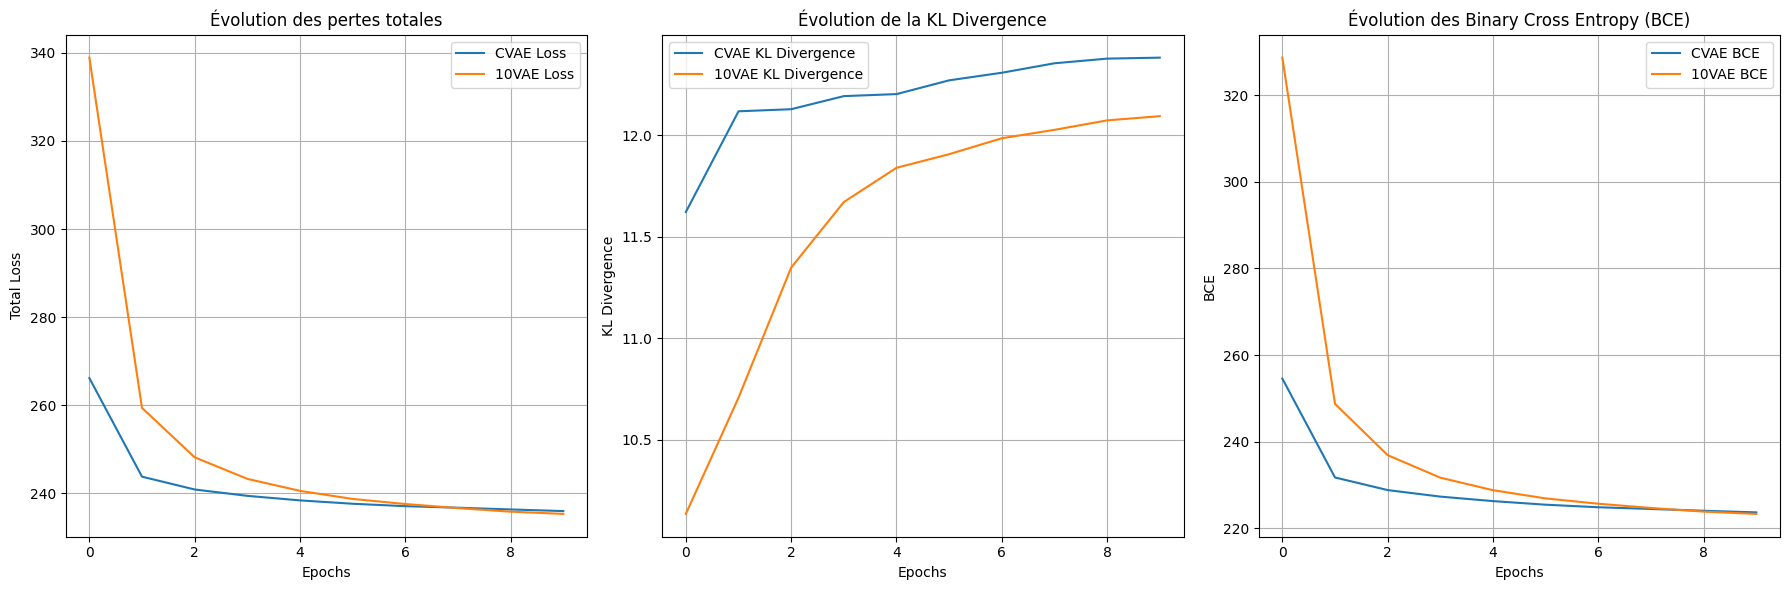

In [32]:
# Affichage de l'évolution des loss

plot_losses(loss_dict['evol_losses'], loss_dict['evol_bce'], loss_dict['evol_kl']) # Losses de validartion ? d'entrainement ?

On remarque ici que l'entraînement est beaucoup plus rapide avec le CVAE qu'avec les VAE. Cela peut s'expliquer par le fait que l'on donne des données de toutes les classes au CVAE, et donc plus de données. Ainsi, même si les images sont différentes d'une classe à l'autre, leur structure reste proche, et le CVAE apprend plus rapidement la structure de nos données. L'entraînement est donc plus rapide.

Néanmoins, la fonction de perte des VAE, au bout de 10 époques, rattrape celle des CVAE : on peut donc supposer qu'avec un plus grand nombre d'époques, les VAE seraient plus performants que le CVAE. Cela est assez logique, car les VAE étant au nombre de 10, ils ont 10 fois plus de poids par rapport au CVAE.

On observe enfin que la KL-Divergence est plus faible pour les VAE que pour le CVAE : la représentation des données dans l'espace latent est plus proche d'une loi normale centrée réduite. Comme chaque VAE se concentre sur une seule classe, il est plus simple de représenter chaque classe comme une loi proche d'une normale dans l'espace latent, ce qui rend cette observation cohérente. On aurait même pu s'attendre à de plus gros écarts entre nos modèles pour cette perte.

#### Pertes sur le jeu de test

In [33]:
# Calcul des pertes pour le CVAE

loss_dict_test = evaluate(model_CVAE_dict, test_loader, device, kl_weight=KL_WEIGHT, have_labels=True)

In [34]:
# Idem pour le VAE

loss_dict_test_vae = {}

for i in range(10):
    name = 'VAE' + str(i)
    loss_dict_test_vae[name] = evaluate(dict_model={name:models_VAE_dict[name]}, test_loader=test_dataloader_class[i], device=device, kl_weight=KL_WEIGHT, have_labels = False)



loss_dict_test_vae_av = {'evol_losses': [], 'evol_bce': [], 'evol_kl': []}

avg_losses = sum(loss_dict_test_vae[f'VAE{k}']['evol_losses'][f'VAE{k}'] for k in range(10)) / 10 # 10 correspond au nombre de classe
avg_bce = sum(loss_dict_test_vae[f'VAE{k}']['evol_bce'][f'VAE{k}'] for k in range(10)) / 10
avg_kl = sum(loss_dict_test_vae[f'VAE{k}']['evol_kl'][f'VAE{k}'] for k in range(10)) / 10


    # Append the averages to the result dictionary

loss_dict_test_vae_av['evol_losses'].append(avg_losses)
loss_dict_test_vae_av['evol_bce'].append(avg_bce)
loss_dict_test_vae_av['evol_kl'].append(avg_kl)


In [35]:
print("Loss sur le jeu de test du CVAE : ", loss_dict_test['evol_losses']['CVAE'])
print("Loss sur le jeu de test des VAE :", loss_dict_test_vae_av['evol_losses'][0])

print("\nLoss BCE sur le jeu de test du CVAE : ", loss_dict_test['evol_bce']['CVAE'])
print("Loss BCE sur le jeu de test des VAE :", loss_dict_test_vae_av['evol_bce'][0])

print("\nLoss KL sur le jeu de test du CVAE : ", loss_dict_test['evol_kl']['CVAE'])
print("Loss KL sur le jeu de test des VAE :", loss_dict_test_vae_av['evol_kl'][0])

Loss sur le jeu de test du CVAE :  237.56867687988282
Loss sur le jeu de test des VAE : 237.7550984375

Loss BCE sur le jeu de test du CVAE :  225.4286048828125
Loss BCE sur le jeu de test des VAE : 225.61521347656247

Loss KL sur le jeu de test du CVAE :  12.140071519470215
Loss KL sur le jeu de test des VAE : 12.139885205078125


Ici, la valeur de la loss obtenue sur le jeu de test est très proche de celle obtenue sur le jeu d'entraînement, pour les deux modèles. Ils ne sont donc pas overfittés, et l'on pourrait entraîner les modèles plus longtemps pour de meilleures performances.

### Comparaison des images reconstruites

In [36]:
# fonction spécifique pour comparer des images générées par VAE et par CAVE

def compare_CVAE_and_VAEs(models_dict, cvae_dict, test_loader, device):

    random_images, random_labels = next(iter(test_loader))
    random_images = random_images.to(device)
    random_labels_one_hot = torch.eye(10)[random_labels].to(device)

    dict_recons = {"CVAE Reconstructions": []}
    dict_recons["VAE Reconstructions"] = []

    # Reconstructions par le CVAE
    cvae_model = cvae_dict["CVAE"][0]
    cvae_model.eval()
    with torch.no_grad():
        cvae_recons, _, _ = cvae_model(random_images, random_labels_one_hot)
        cvae_recons = cvae_recons.cpu().numpy().squeeze()
        dict_recons["CVAE Reconstructions"] = cvae_recons

    # Reconstructions par les VAE spécifiques aux labels
    for i, image in enumerate(random_images):
        label = random_labels[i].item()
        vae_model = models_dict[f"VAE{label}"][0]  # on utilise le modèle correspondant au label (ex: VAE2 pour label=2)
        vae_model.eval()

        with torch.no_grad():
            image = image.unsqueeze(0)
            vae_recons, _, _ = vae_model(image)
            vae_recons = vae_recons.cpu().numpy().squeeze()
            dict_recons[f"VAE Reconstructions"].append(vae_recons)

    random_images = random_images.cpu().numpy().squeeze()

    image_comparison_with_vaes(random_images, random_labels, dict_recons)


# Affiche les images originales et leurs reconstructions par le CVAE et les VAE spécialisés.
def image_comparison_with_vaes(original_images, labels, dict_recons, n_images=6):

    original_images = original_images[:n_images]
    labels = labels[:n_images]

    n_rows = len(dict_recons) + 1
    fig, ax = plt.subplots(n_rows, n_images, figsize=(20, 3 * n_rows))

    for i in range(n_images):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, i].set_title(f"Original (Label: {labels[i].item()})")

    # Affichage des reconstructions
    for row, (key, recons) in enumerate(dict_recons.items(), start=1):
        for i in range(n_images):
            if "VAE" in key:  # Pour les modèles VAE, on prend la reconstruction correspondante à la classe
                recons_image = recons[i]
            else:  # Pour le CVAE
                recons_image = recons[i]
            ax[row, i].imshow(recons_image, cmap='gray')
            ax[row, i].axis('off')
        ax[row, 0].set_title(key)

    plt.tight_layout()
    plt.show()

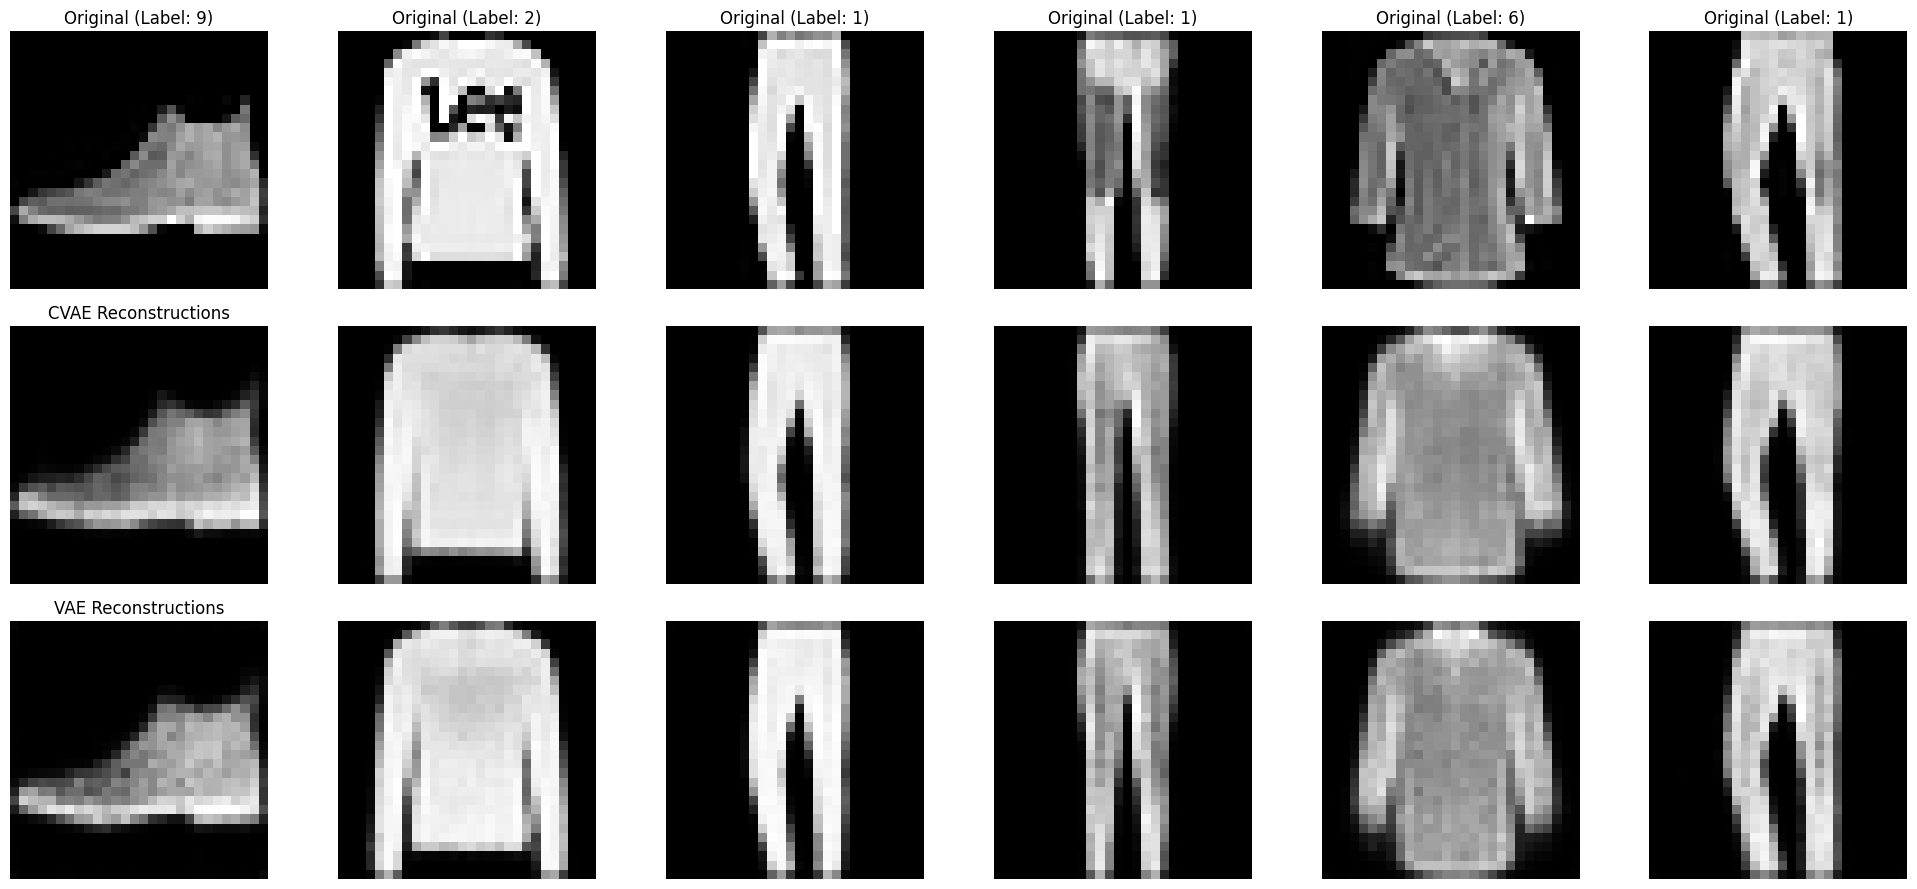

In [37]:

compare_CVAE_and_VAEs(models_VAE_dict, model_CVAE_dict, test_loader, device)

En regardant les images ci-dessus, on n'observe pas de différences flagrantes entre la reconstruction par les VAE et par les CVAE. Cela est cohérent avec les résultats que nous avons obtenus précédemment, avec des pertes BCE ayant des valeurs similaires pour les deux modèles.

### Génération d'images


In [38]:
#  Génère et affiche des échantillons générés par un CVAE et des VAE spécialisés (par classe)

def generate_samples_plot_vae(models_dict, cvae_dict, num_samples=10):

    # S'assurer que tous les modèles sont en mode évaluation
    cvae_model = cvae_dict["CVAE"][0]
    cvae_model.eval()
    for model_name, (model, _) in models_dict.items():
        model.eval()

    with torch.no_grad():
        y = torch.eye(10).to(device)  # Labels conditionnels pour les 10 classes

        num_rows = 2  # Lignes : 1 CVAE + 1 VAEs
        num_cols = num_samples + 1
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 2 * num_rows))

        z_cvae = torch.randn(num_samples, cvae_model.latent_dim).to(device)
        cvae_samples = cvae_model.decode(z_cvae, y).cpu().view(num_samples, 1, 28, 28)

        ax[0, 0].text(0.5, 0.5, 'CVAE', horizontalalignment='center',
                      verticalalignment='center', fontsize=12, transform=ax[0, 0].transAxes)
        ax[0, 0].axis('off')

        # Afficher les échantillons générés par le CVAE
        for j in range(1, num_samples + 1):
            ax[0, j].imshow(cvae_samples[j-1].squeeze(0), cmap='gray')
            ax[0, j].axis('off')
            ax[0, j].set_title(f"Label={j-1}")


        ax[1, 0].text(0.5, 0.5, "VAE", horizontalalignment='center',
                    verticalalignment='center', fontsize=12, transform=ax[1, 0].transAxes)
        ax[1, 0].axis('off')
        for i in range(10):
            vae_model = models_dict["VAE"+str(i)][0]
            z_vae = torch.randn(1, vae_model.latent_dim).to(device)  # Un vecteur latent par VAE
            vae_samples = vae_model.decode(z_vae).cpu().view(1, 28, 28)

            ax[1, i+1].imshow(vae_samples.squeeze(0), cmap='gray')
            ax[1, i+1].axis('off')

        plt.tight_layout()
        plt.show()

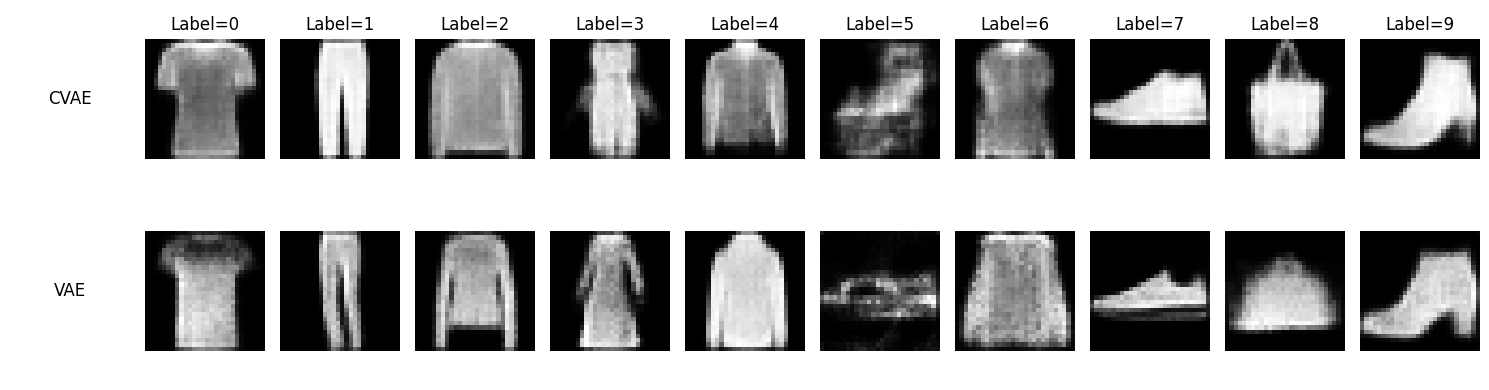

In [39]:
generate_samples_plot_vae(models_VAE_dict, model_CVAE_dict)


Comme précédemment, il est difficile de comparer les images générées par les deux modèles avec aussi peu d'images. Néanmoins, il semblerait que les images générées par le CVAE soient plus réalistes que celles générées par le VAE. On remarque également des difficultés plus importantes pour certaines catégories d'articles, ici les sandales, les sacs et les talons (labels 5, 8 et 9).

In [40]:
# générer des samples avec le dictionnaire de VAE
# Si la catégorie est spécifiée, on génère des images de cette catégorie, sinon on utilise une catégorie aléatoire

def generate_samples_dict_VAE(model_dict, num_samples=10, category=-1):

    with torch.no_grad():
        if category == -1:
            y = generate_random_matrix(num_samples, 10).to(device)
        else:
            y = torch.zeros((num_samples, 10), dtype=torch.int).to(device)
            y[:, category] = 1

        z = torch.randn(num_samples, 10).to(device)

        samples_list = []
        for i in range(num_samples):
            model = model_dict["VAE"+str(int(torch.argmax(y[i])))][0]
            samples_list.append(model.decode(z[i])[0])

        samples = torch.stack(samples_list)
        return {"VAE":(samples, y)}


In [41]:
samples_dict_CVAE = generate_samples_dict(model_CVAE_dict, 10000)
samples_dict_VAE = generate_samples_dict_VAE(models_VAE_dict, 10000)


### Résultats des tests automatiques

#### Test du classifieur

In [42]:
accuracy_CVAE = eval_classif_dict(samples_dict_CVAE)
accuracy_VAE = eval_classif_dict(samples_dict_VAE)

print(accuracy_CVAE, accuracy_VAE)

{'CVAE': 83.55} {'VAE': 90.57}


Comme les résultats varient légèrement d'une exécution à l'autre, nous avons entraîné plusieurs fois les modèles, puis affiché les résultats sous forme de boxplot.

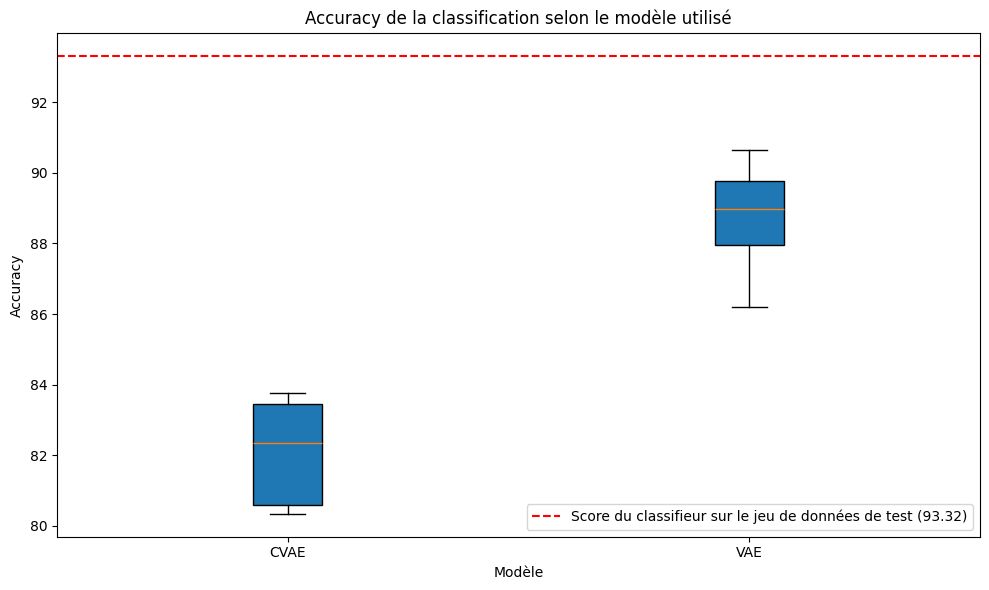

In [43]:
accuracy_dict_VAE = {}
list_accuracy_CVAE = [83.45, 83.77, 83.11, 81.24, 80.58, 83.71, 80.52, 82.34, 80.34]
accuracy_dict_VAE['CVAE'] = list_accuracy_CVAE
list_accuracy_VAE = [89.54, 87.89, 89.77, 90.03, 88.78, 88.99, 87.97, 90.64, 86.21]
accuracy_dict_VAE['VAE'] = list_accuracy_VAE

plot_boxplots(accuracy_dict_VAE, horizontal_line=accuracy_test, titre = "Accuracy de la classification selon le modèle utilisé", ylabel = "Accuracy")

On observe ici que le classifieur s'en sort beaucoup mieux sur les données générées par le VAE que sur celles générées par le CVAE. Cela signifie que le type d'article est plus reconnaissable avec le VAE. Cela peut s'expliquer par le fait que les modèles du VAE sont chacun spécialisés sur un type d'article, et chaque modèle se concentre donc davantage sur les spécificités du type d'article qui lui correspond.

#### Score FID

In [44]:
fid_score_vae = comupte_fid_dict(samples_dict_VAE, test_loader, batch_size=32)
fid_score_cvae = comupte_fid_dict(samples_dict_CVAE, test_loader, batch_size=32)

print(fid_score_cvae)
print(fid_score_vae)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 38.7MB/s]
Processing Batches: 100%|██████████| 79/79 [00:31<00:00,  2.52it/s]


{'CVAE': tensor(0.3084, device='cuda:0')}
{'VAE': tensor(0.3591, device='cuda:0')}


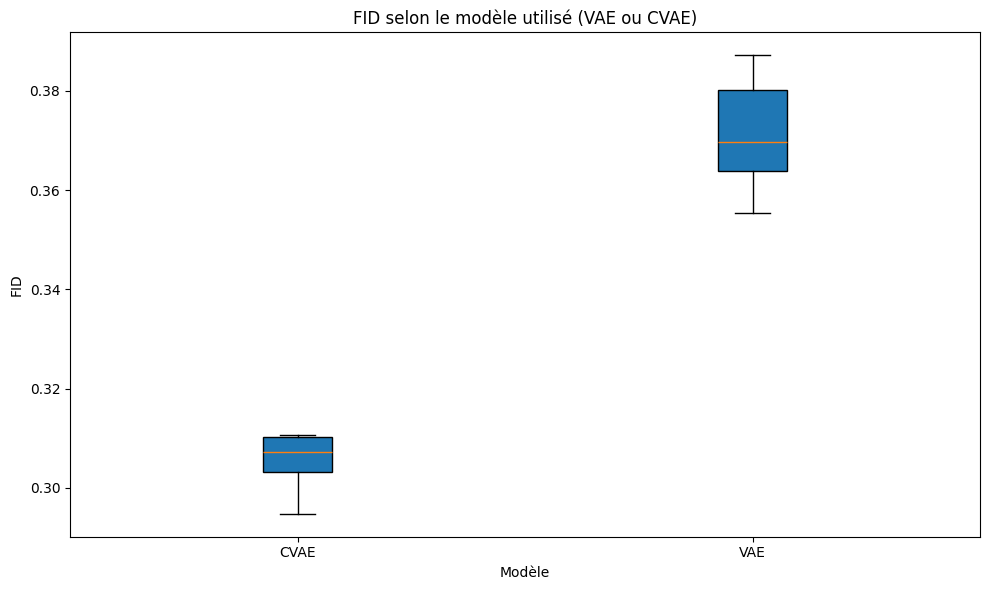

In [45]:
fid_dict_VAE = {}
list_fid_CVAE = [0.3101, 0.3105, 0.3106, 0.3060, 0.3084, 0.2994, 0.3044, 0.2948]
fid_dict_VAE['CVAE'] = list_fid_CVAE
list_fid_VAE = [0.3652, 0.3821, 0.3797, 0.3609, 0.3743, 0.3872, 0.3555, 0.3650]
fid_dict_VAE['VAE'] = list_fid_VAE

plot_boxplots(fid_dict_VAE, titre = "FID selon le modèle utilisé (VAE ou CVAE)", ylabel = "FID")

On obtient ici de meilleurs résultats pour le FID avec le CVAE qu'avec le VAE. Cela signifie que le CVAE a mieux compris la structure des données que le VAE, et qu'il a donc tendance à générer de meilleures images.

### Conclusion sur cette partie

En conclusion, l'architecture CVAE présente plusieurs avantages par rapport aux VAE pour générer des données d'une classe spécifique : le nombre de poids à stocker est plus faible, l'entraînement est plus rapide et les données générées sont de meilleure qualité.

## V) Comparaison de différentes architectures de CVAE

Nous allons maintenant comparer l'architecture de différentes structures de modèles pour évaluer leurs performances sur notre problématique.

### Définition de l'architecture des modèles

Nous définissons ci-dessous trois autres architectures de modèles, que nous allons comparer à celles vues précédemment

In [46]:
class CVAE2(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE2, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 128, kernel_size=5, stride=2, padding=2),  # 11 channels: 1 for image + 10 for one-hot labels # Output: (128, 13, 13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 2, 2)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(64 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(64 * 2 * 2, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + 10, 64 * 2 * 2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding = 1),  # Output: (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding = 1),  # Output: (128, 13, 13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=5, stride=2, padding=2, output_padding = 1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, y):
        y = y.view(-1, 10, 1, 1)
        y = y.expand(-1, -1, 28, 28)
        x = torch.cat([x, y], dim=1)

        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = torch.cat((z, y), dim=1)
        z = z.view(z.size(0), -1)
        z = self.fc_decode(z)
        z = z.view(-1, 64, 2, 2)

        x = self.decoder(z)
        return x


    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.sample(mu, logvar)
        return self.decode(z, y), mu, logvar

Pour construire les deux modèles suivants, je me suis inspiré de l'architecture de VGG, avec deux variantes.

In [47]:
class CVAE3(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE3, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=4, stride=2, padding=2),
            nn.Conv2d(32, 32, kernel_size=4, stride=1, padding=1), # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2),
            nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim+10, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=1),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=2),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=1, padding=1),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=2),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, y):
        y = y.view(-1, 10, 1, 1)
        y = y.expand(-1, -1, 28, 28)
        x = torch.cat([x, y], dim=1)

        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):

        z = torch.cat((z, y), dim=1)
        z = z.view(z.size(0), -1)
        z = self.fc_decode(z)

        z = z.view(-1, 128, 4, 4)

        x = self.decoder(z)
        return x


    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.sample(mu, logvar)
        return self.decode(z, y), mu, logvar

In [48]:
class CVAE4(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE4, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=3, stride=1, padding=1),  #Output: (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  #Output: (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #Output: (32, 14, 14)

            # Bloc 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  #Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  #Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #Output: (64, 7, 7)

            # Bloc 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  #Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),   #Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_decode = nn.Linear(latent_dim+10, 128 * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            # Bloc 3 (inverse)
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Bloc 2 (inverse)
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Bloc 1 (inverse)
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )


    def encode(self, x, y):
        y = y.view(-1, 10, 1, 1)
        y = y.expand(-1, -1, 28, 28)
        x = torch.cat([x, y], dim=1)

        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = torch.cat((z, y), dim=1)
        z = z.view(z.size(0), -1)
        z = self.fc_decode(z)

        z = z.view(-1, 128, 7, 7)
        x = self.decoder(z)
        return x


    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.sample(mu, logvar)
        return self.decode(z, y), mu, logvar

On utilise ici les mêmes hyperparamètres que lors de la partie précédente.

In [49]:
models_dict = {
    'CVAE1': config_model(CVAE, LATENT_DIM, LEARNING_RATE),
    'CVAE2': config_model(CVAE2, LATENT_DIM, LEARNING_RATE),
    'CVAE3': config_model(CVAE3, LATENT_DIM, LEARNING_RATE),
    'CVAE4': config_model(CVAE4, LATENT_DIM, LEARNING_RATE),
}

### Entraînement des modèles

In [50]:
loss_dict = train(dict_model=models_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

Epoch 1: Model CVAE1 - Loss: 262.9550, BCE: 251.0124, KLD: 11.9426
Epoch 1: Model CVAE2 - Loss: 268.0356, BCE: 257.3396, KLD: 10.6960
Epoch 1: Model CVAE3 - Loss: 264.1669, BCE: 255.3438, KLD: 8.8231
Epoch 1: Model CVAE4 - Loss: 270.4305, BCE: 258.9599, KLD: 11.4707
Epoch 2: Model CVAE1 - Loss: 243.4225, BCE: 231.2315, KLD: 12.1910
Epoch 2: Model CVAE2 - Loss: 245.1242, BCE: 234.2674, KLD: 10.8568
Epoch 2: Model CVAE3 - Loss: 247.2208, BCE: 237.8335, KLD: 9.3873
Epoch 2: Model CVAE4 - Loss: 243.9966, BCE: 232.7893, KLD: 11.2073
Epoch 3: Model CVAE1 - Loss: 240.6305, BCE: 228.4684, KLD: 12.1622
Epoch 3: Model CVAE2 - Loss: 241.6194, BCE: 230.6350, KLD: 10.9844
Epoch 3: Model CVAE3 - Loss: 243.4907, BCE: 233.5248, KLD: 9.9659
Epoch 3: Model CVAE4 - Loss: 240.4381, BCE: 228.9059, KLD: 11.5322
Epoch 4: Model CVAE1 - Loss: 239.1484, BCE: 226.9500, KLD: 12.1984
Epoch 4: Model CVAE2 - Loss: 239.9830, BCE: 228.8275, KLD: 11.1554
Epoch 4: Model CVAE3 - Loss: 241.5552, BCE: 231.1605, KLD: 10.394

### Affichage des pertes de nos modèles

#### Pertes au cours de l'entraînement

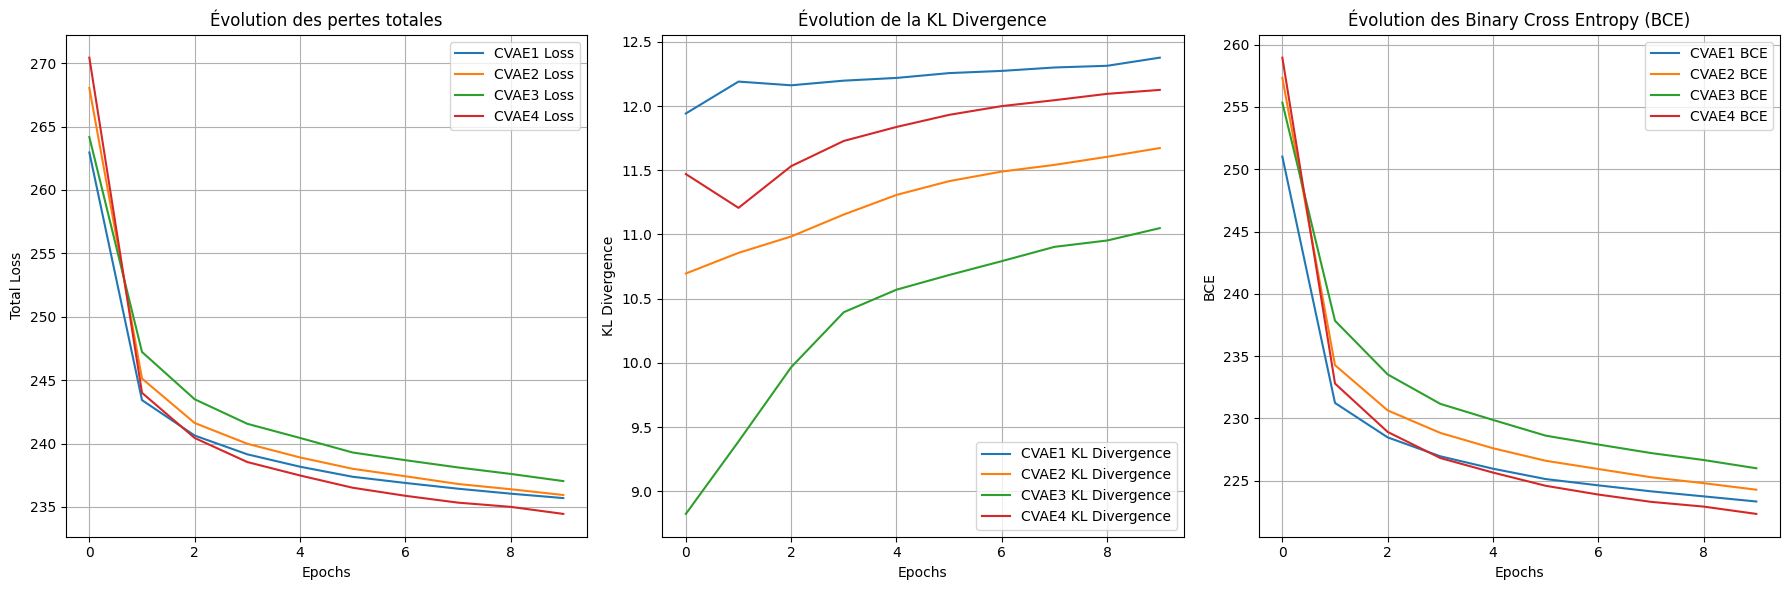

In [51]:
plot_losses(loss_dict['evol_losses'], loss_dict['evol_bce'], loss_dict['evol_kl'])

Sur les données d'entraînement, le modèle CVAE4 semble plus performant, suivi du CVAE1, du CVAE2 et du CVAE3. La vitesse d'entraînement des différents modèles est dans l'ensemble assez similaire, bien que le modèle CVAE1 semble converger un peu plus vite.

#### Pertes sur le jeu de test

In [52]:
loss_dict_test = evaluate(models_dict, test_loader, device, kl_weight=KL_WEIGHT, have_labels=True)


print("Loss sur le jeu de test du CVAE1 : ", loss_dict_test['evol_losses']['CVAE1'])
print("Loss sur le jeu de test des CVAE2 :", loss_dict_test['evol_losses']['CVAE2'])
print("Loss sur le jeu de test du CVAE3 : ", loss_dict_test['evol_losses']['CVAE3'])
print("Loss sur le jeu de test des CVAE4 :", loss_dict_test['evol_losses']['CVAE4'])

print("\nLoss BCE sur le jeu de test du CVAE1 : ", loss_dict_test['evol_bce']['CVAE1'])
print("Loss BCE sur le jeu de test du CVAE2 : ", loss_dict_test['evol_bce']['CVAE2'])
print("Loss BCE sur le jeu de test du CVAE3 : ", loss_dict_test['evol_bce']['CVAE3'])
print("Loss BCE sur le jeu de test du CVAE4 : ", loss_dict_test['evol_bce']['CVAE4'])

print("\nLoss KL sur le jeu de test du CVAE1 : ", loss_dict_test['evol_kl']['CVAE1'])
print("Loss KL sur le jeu de test du CVAE2 : ", loss_dict_test['evol_kl']['CVAE2'])
print("Loss KL sur le jeu de test du CVAE3 : ", loss_dict_test['evol_kl']['CVAE3'])
print("Loss KL sur le jeu de test du CVAE4 : ", loss_dict_test['evol_kl']['CVAE4'])

Loss sur le jeu de test du CVAE1 :  237.49496403808593
Loss sur le jeu de test des CVAE2 : 237.26700512695314
Loss sur le jeu de test du CVAE3 :  239.6836279296875
Loss sur le jeu de test des CVAE4 : 236.6490729248047

Loss BCE sur le jeu de test du CVAE1 :  225.17211245117187
Loss BCE sur le jeu de test du CVAE2 :  225.71162048339843
Loss BCE sur le jeu de test du CVAE3 :  228.70601516113283
Loss BCE sur le jeu de test du CVAE4 :  224.71634790039062

Loss KL sur le jeu de test du CVAE1 :  12.322851695251465
Loss KL sur le jeu de test du CVAE2 :  11.555384132385253
Loss KL sur le jeu de test du CVAE3 :  10.977613400268554
Loss KL sur le jeu de test du CVAE4 :  11.932725643920898


### Comparaison des images reconstruites

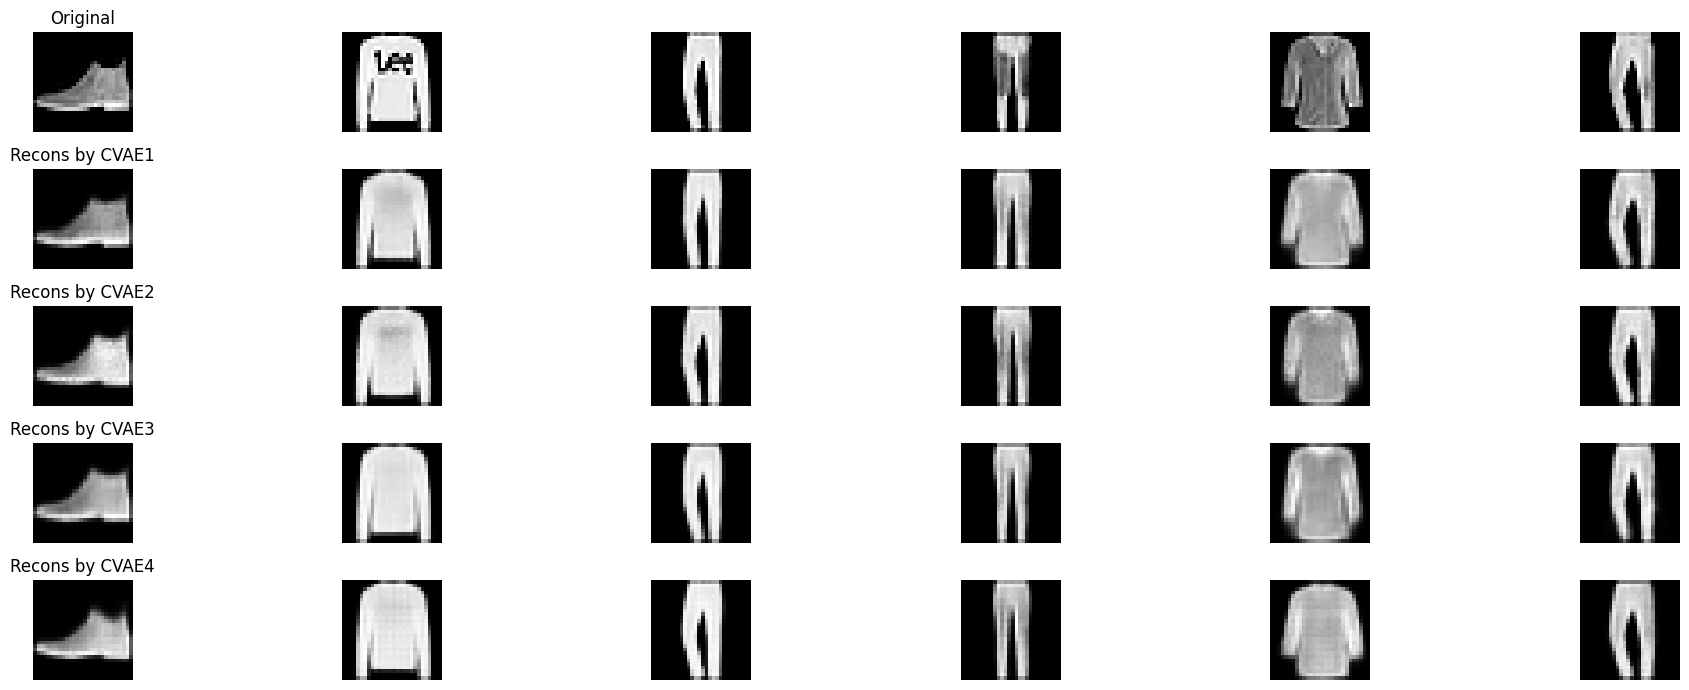

In [53]:
compare_model_reconstructions(models_dict, test_loader, device)

Le reconstruction est très similaire pour les 4 modèles.

### Génération d'images

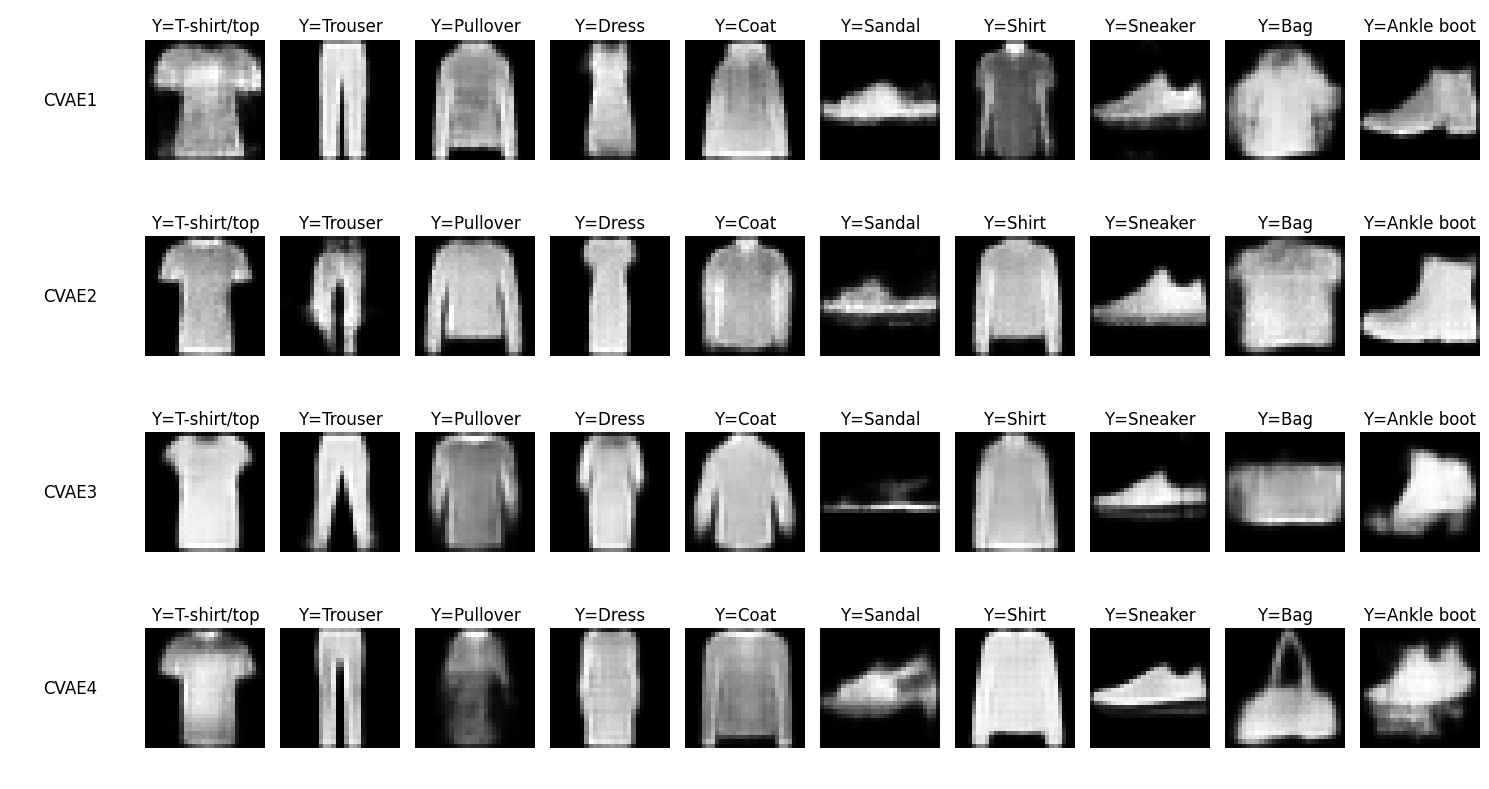

In [54]:
generate_samples_plot(models_dict=models_dict)

On n'observe pas de différence significative dans la qualité des images générées

In [55]:
samples_dict = generate_samples_dict(models_dict, 10000)

### Résultats des tests automatiques

#### Test du classifieur

In [56]:
accuracy_latent = eval_classif_dict(samples_dict)

print(accuracy_latent)

{'CVAE1': 82.17, 'CVAE2': 80.98, 'CVAE3': 79.21, 'CVAE4': 82.54}


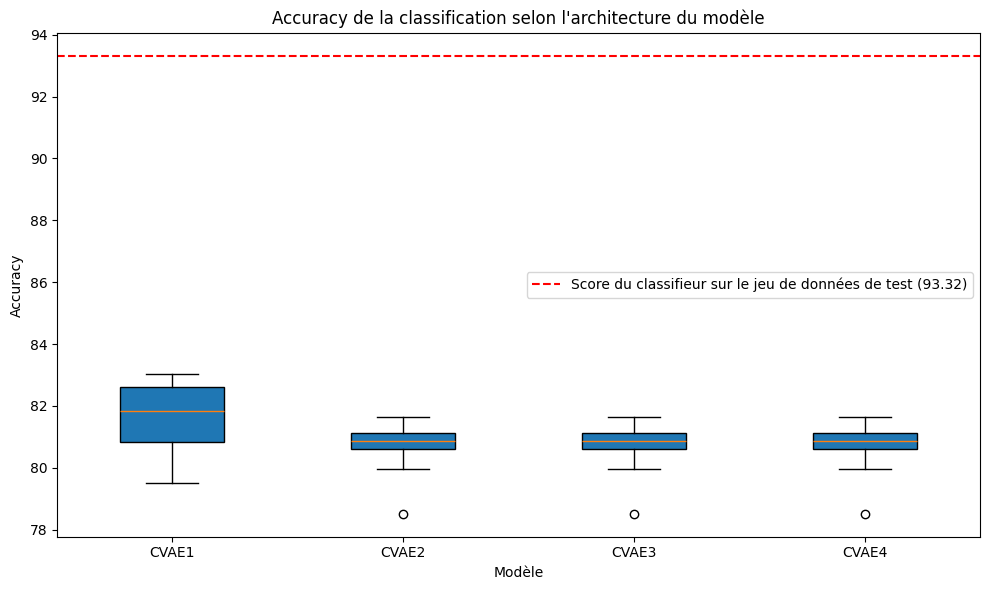

In [57]:
accuracy_dict_model = {}
list_accuracy_CVAE1 = [79.51, 82.4, 81.92, 82.69, 83.02, 82.78, 80.71, 81.2, 81.76, 80.33]
accuracy_dict_model['CVAE1'] = list_accuracy_CVAE1
list_accuracy_CVAE2 = [80.72, 81.15, 81.21, 81.07, 80.55, 80.9, 79.95, 81.63, 80.85, 78.51]
accuracy_dict_model['CVAE2'] = list_accuracy_CVAE2
list_accuracy_CVAE3 = [78.61, 77.02, 79.11, 77.91, 76.94, 82.1, 77.14, 76.51, 78.21, 77.23]
accuracy_dict_model['CVAE3'] = list_accuracy_CVAE2
list_accuracy_CVAE4 = [80.54, 80.55, 80.4, 80.45, 77.62, 81.56, 80.43]
accuracy_dict_model['CVAE4'] = list_accuracy_CVAE2

plot_boxplots(accuracy_dict_model, horizontal_line=accuracy_test, titre = "Accuracy de la classification selon l'architecture du modèle", ylabel = "Accuracy")

#### Score FID

In [58]:
fid_score = comupte_fid_dict(samples_dict, test_loader, batch_size=32)

print(fid_score)

Processing Batches: 100%|██████████| 79/79 [00:31<00:00,  2.47it/s]


{'CVAE1': tensor(0.3052, device='cuda:0'), 'CVAE2': tensor(0.3203, device='cuda:0'), 'CVAE3': tensor(0.3142, device='cuda:0'), 'CVAE4': tensor(0.3686, device='cuda:0')}


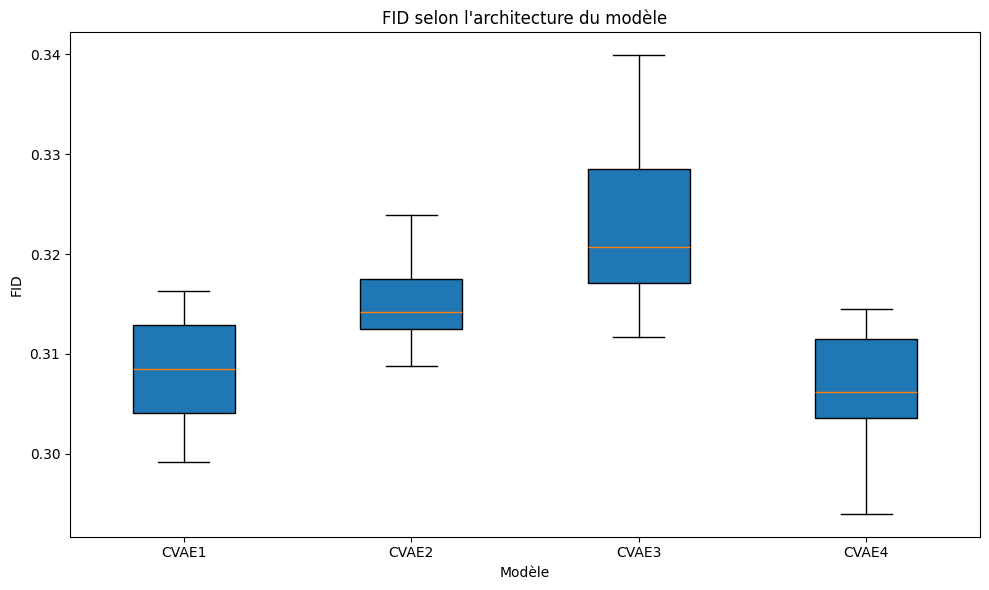

In [59]:
fid_dict_model = {}
list_fid_CVAE1 = [0.3135, 0.3016, 0.2992, 0.3102, 0.3068, 0.3163, 0.3049, 0.3127]
fid_dict_model['CVAE1'] = list_fid_CVAE1
list_fid_CVAE2 = [0.3145, 0.3140, 0.3171, 0.3186, 0.3239, 0.3132, 0.3103, 0.3088]
fid_dict_model['CVAE2'] = list_fid_CVAE2
list_fid_CVAE3 = [0.3117, 0.3279, 0.3216, 0.3302, 0.3198, 0.3146, 0.3399, 0.3179]
fid_dict_model['CVAE3'] = list_fid_CVAE3
list_fid_CVAE4 = [0.3115, 0.3036, 0.3062, 0.3145, 0.2940]
fid_dict_model['CVAE4'] = list_fid_CVAE4

plot_boxplots(fid_dict_model, titre = "FID selon l'architecture du modèle", ylabel = "FID")

### Conclusion sur cette partie

Nous avons, au cours de cette partie, obtenu des résultats assez proches pour nos quatre architectures de modèle. Néanmoins, avec les paramètres que nous avons utilisés, le modèle CVAE1 semble légèrement plus performant, nous allons donc le conserver pour la suite.

Il faut néanmoins souligner que les modèles CVAE2, CVAE3 et CVAE4 sont des modèles légèrement plus grands que le CVAE1, et il serait intéressant de les tester avec un temps d'entrainement plus long.

## VI) Calibration de la dimension de l'espace latent

La taille de l'espace latent est un paramètre essentiel dans la calibration d'un VAE. En effet, c'est la petite taille de l'espace latent par rapport aux données d'entrée qui oblige le réseau à retenir uniquement les informations essentielles, et donc à apprendre. Avec un espace latent trop grand, le VAE aura tendance à se surentraîner. À l'inverse, un espace latent trop petit limitera les informations que le réseau pourra apprendre, réduisant ainsi ses performances. Il est donc crucial de calibrer ce paramètre pour obtenir un réseau performant.

### Définition de l'architecture des classes

Je réutilise ici l'architecture du modèle le plus performant lors de la partie précédente, en faisant varier la taille de l'espace latent.

In [60]:
models_dict_latent = {
    '4CVAE': config_model(CVAE, 4, LEARNING_RATE),
    '6CVAE': config_model(CVAE, 6, LEARNING_RATE),
    '10CVAE': config_model(CVAE, 10, LEARNING_RATE),
    '16CVAE': config_model(CVAE, 16, LEARNING_RATE),
    '32CVAE': config_model(CVAE, 32, LEARNING_RATE),
    '64CVAE': config_model(CVAE, 64, LEARNING_RATE),
    '128CVAE': config_model(CVAE, 128, LEARNING_RATE),
}

### Entrainement des modèles

On reprend les hyperparamètres utilisés précedemment.

In [61]:
loss_dict_latent = train(dict_model=models_dict_latent, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

Epoch 1: Model 4CVAE - Loss: 268.7184, BCE: 261.2940, KLD: 7.4244
Epoch 1: Model 6CVAE - Loss: 264.1852, BCE: 254.3458, KLD: 9.8394
Epoch 1: Model 10CVAE - Loss: 263.6057, BCE: 251.5262, KLD: 12.0796
Epoch 1: Model 16CVAE - Loss: 268.0340, BCE: 254.9426, KLD: 13.0915
Epoch 1: Model 32CVAE - Loss: 268.4793, BCE: 253.9801, KLD: 14.4991
Epoch 1: Model 64CVAE - Loss: 273.2318, BCE: 258.1805, KLD: 15.0513
Epoch 1: Model 128CVAE - Loss: 280.9344, BCE: 266.0859, KLD: 14.8485
Epoch 2: Model 4CVAE - Loss: 247.9970, BCE: 240.3580, KLD: 7.6389
Epoch 2: Model 6CVAE - Loss: 244.8672, BCE: 234.8668, KLD: 10.0004
Epoch 2: Model 10CVAE - Loss: 243.5728, BCE: 231.2234, KLD: 12.3494
Epoch 2: Model 16CVAE - Loss: 244.0386, BCE: 230.6941, KLD: 13.3446
Epoch 2: Model 32CVAE - Loss: 245.5731, BCE: 231.8251, KLD: 13.7480
Epoch 2: Model 64CVAE - Loss: 247.1182, BCE: 233.5040, KLD: 13.6142
Epoch 2: Model 128CVAE - Loss: 248.9016, BCE: 235.6798, KLD: 13.2218
Epoch 3: Model 4CVAE - Loss: 245.5332, BCE: 237.8894,

### Affichage des pertes de nos modèles

#### Pertes au cours de l'entraînement

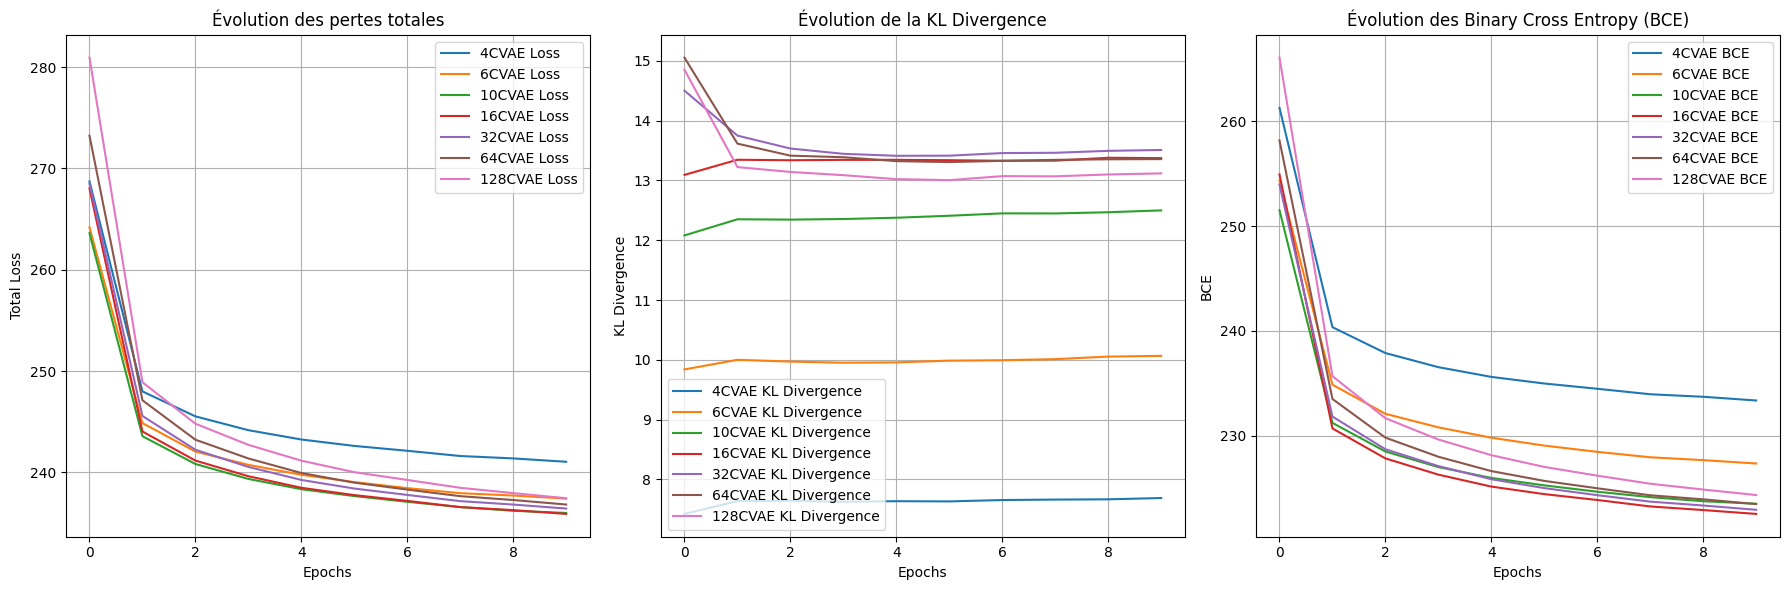

In [86]:
plot_losses(loss_dict_latent['evol_losses'], loss_dict_latent['evol_bce'], loss_dict_latent['evol_kl'])

#### Pertes sur le jeu de test

In [89]:
loss_dict_test = evaluate(models_dict_latent, test_loader, device, kl_weight=KL_WEIGHT, have_labels=True)

In [90]:
print("Loss sur le jeu de test du 4CVAE : ", loss_dict_test['evol_losses']['4CVAE'])
print("Loss sur le jeu de test du 6CVAE :", loss_dict_test['evol_losses']['6CVAE'])
print("Loss sur le jeu de test du 10CVAE : ", loss_dict_test['evol_losses']['10CVAE'])
print("Loss sur le jeu de test du 16CVAE :", loss_dict_test['evol_losses']['16CVAE'])
print("Loss sur le jeu de test du 32CVAE :", loss_dict_test['evol_losses']['32CVAE'])
print("Loss sur le jeu de test du 64CVAE :", loss_dict_test['evol_losses']['64CVAE'])
print("Loss sur le jeu de test du 128CVAE :", loss_dict_test['evol_losses']['128CVAE'])

print("\nLoss BCE sur le jeu de test du 4CVAE : ", loss_dict_test['evol_bce']['4CVAE'])
print("Loss BCE sur le jeu de test du 6CVAE : ", loss_dict_test['evol_bce']['6CVAE'])
print("Loss BCE sur le jeu de test du 10CVAE : ", loss_dict_test['evol_bce']['10CVAE'])
print("Loss BCE sur le jeu de test du 16CVAE : ", loss_dict_test['evol_bce']['16CVAE'])
print("Loss BCE sur le jeu de test du 32CVAE : ", loss_dict_test['evol_bce']['32CVAE'])
print("Loss BCE sur le jeu de test du 64CVAE : ", loss_dict_test['evol_bce']['64CVAE'])
print("Loss BCE sur le jeu de test du 128CVAE : ", loss_dict_test['evol_bce']['128CVAE'])

print("\nLoss KL sur le jeu de test du 4CVAE : ", loss_dict_test['evol_kl']['4CVAE'])
print("Loss KL sur le jeu de test du 6CVAE : ", loss_dict_test['evol_kl']['6CVAE'])
print("Loss KL sur le jeu de test du 10CVAE : ", loss_dict_test['evol_kl']['10CVAE'])
print("Loss KL sur le jeu de test du 16CVAE : ", loss_dict_test['evol_kl']['16CVAE'])
print("Loss KL sur le jeu de test du 32CVAE : ", loss_dict_test['evol_kl']['32CVAE'])
print("Loss KL sur le jeu de test du 64CVAE : ", loss_dict_test['evol_kl']['64CVAE'])
print("Loss KL sur le jeu de test du 128CVAE : ", loss_dict_test['evol_kl']['128CVAE'])

Loss sur le jeu de test du 4CVAE :  235.81246225585937
Loss sur le jeu de test du 6CVAE : 230.08954294433593
Loss sur le jeu de test du 10CVAE :  226.03330432128905
Loss sur le jeu de test du 16CVAE : 225.543727734375
Loss sur le jeu de test du 32CVAE : 225.54376801757812
Loss sur le jeu de test du 64CVAE : 226.41411845703124
Loss sur le jeu de test du 128CVAE : 226.59578625488282

Loss BCE sur le jeu de test du 4CVAE :  235.0389744873047
Loss BCE sur le jeu de test du 6CVAE :  229.08346918945313
Loss BCE sur le jeu de test du 10CVAE :  224.76561298828125
Loss BCE sur le jeu de test du 16CVAE :  224.20429350585937
Loss BCE sur le jeu de test du 32CVAE :  224.1729162109375
Loss BCE sur le jeu de test du 64CVAE :  225.10115639648438
Loss BCE sur le jeu de test du 128CVAE :  225.2397513671875

Loss KL sur le jeu de test du 4CVAE :  7.7348716423034665
Loss KL sur le jeu de test du 6CVAE :  10.060743507385254
Loss KL sur le jeu de test du 10CVAE :  12.676917404174805
Loss KL sur le jeu de t

### Comparaison des images reconstruites

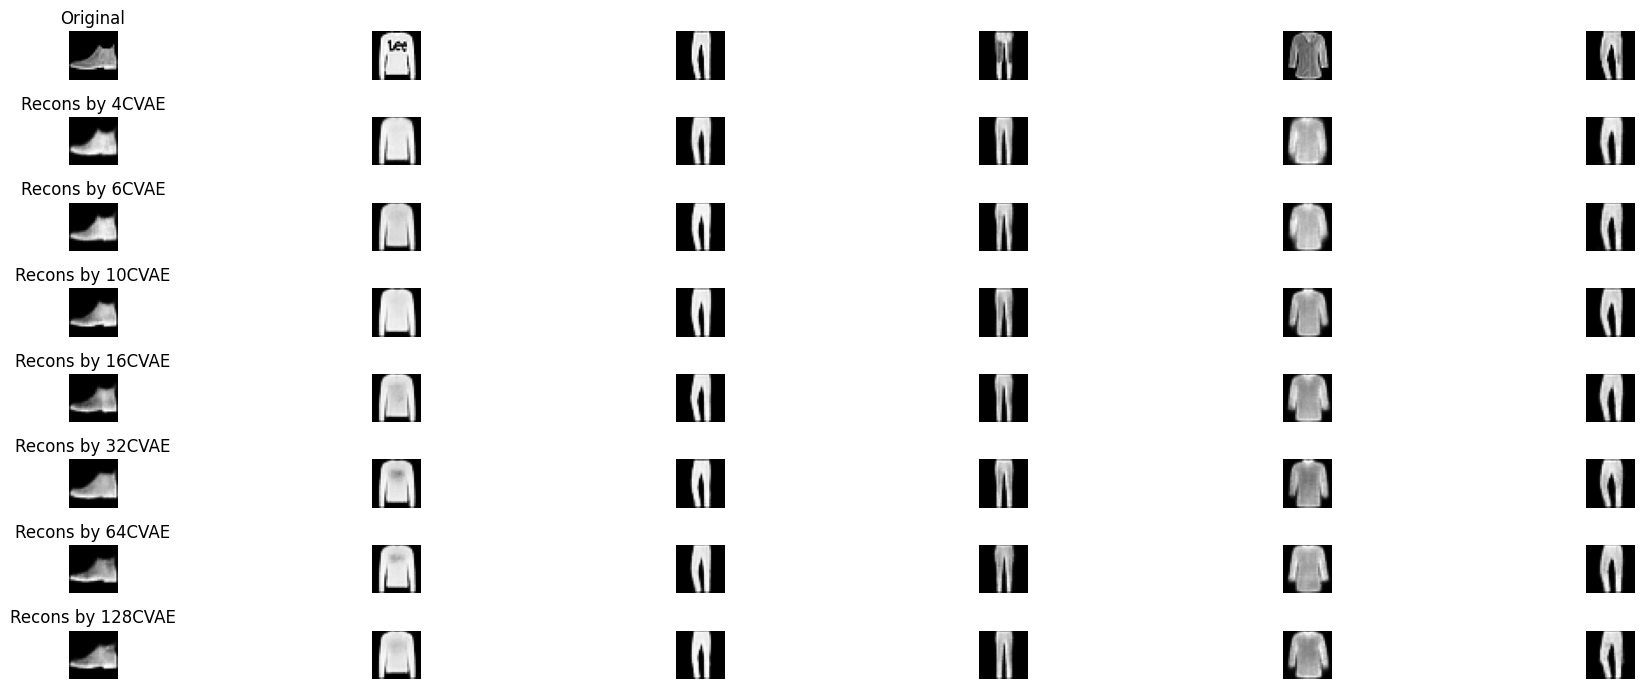

In [64]:
compare_model_reconstructions(models_dict_latent, test_loader, device)

On observe encore une fois peu de différence entre les images reconstruites, même si le modèle avec un espace latent de 16 semble donner des résultats légèrement meilleurs (avant sombre plus visible sur la chaussure et logo sur le pull plus distinct).

### Génération d'images

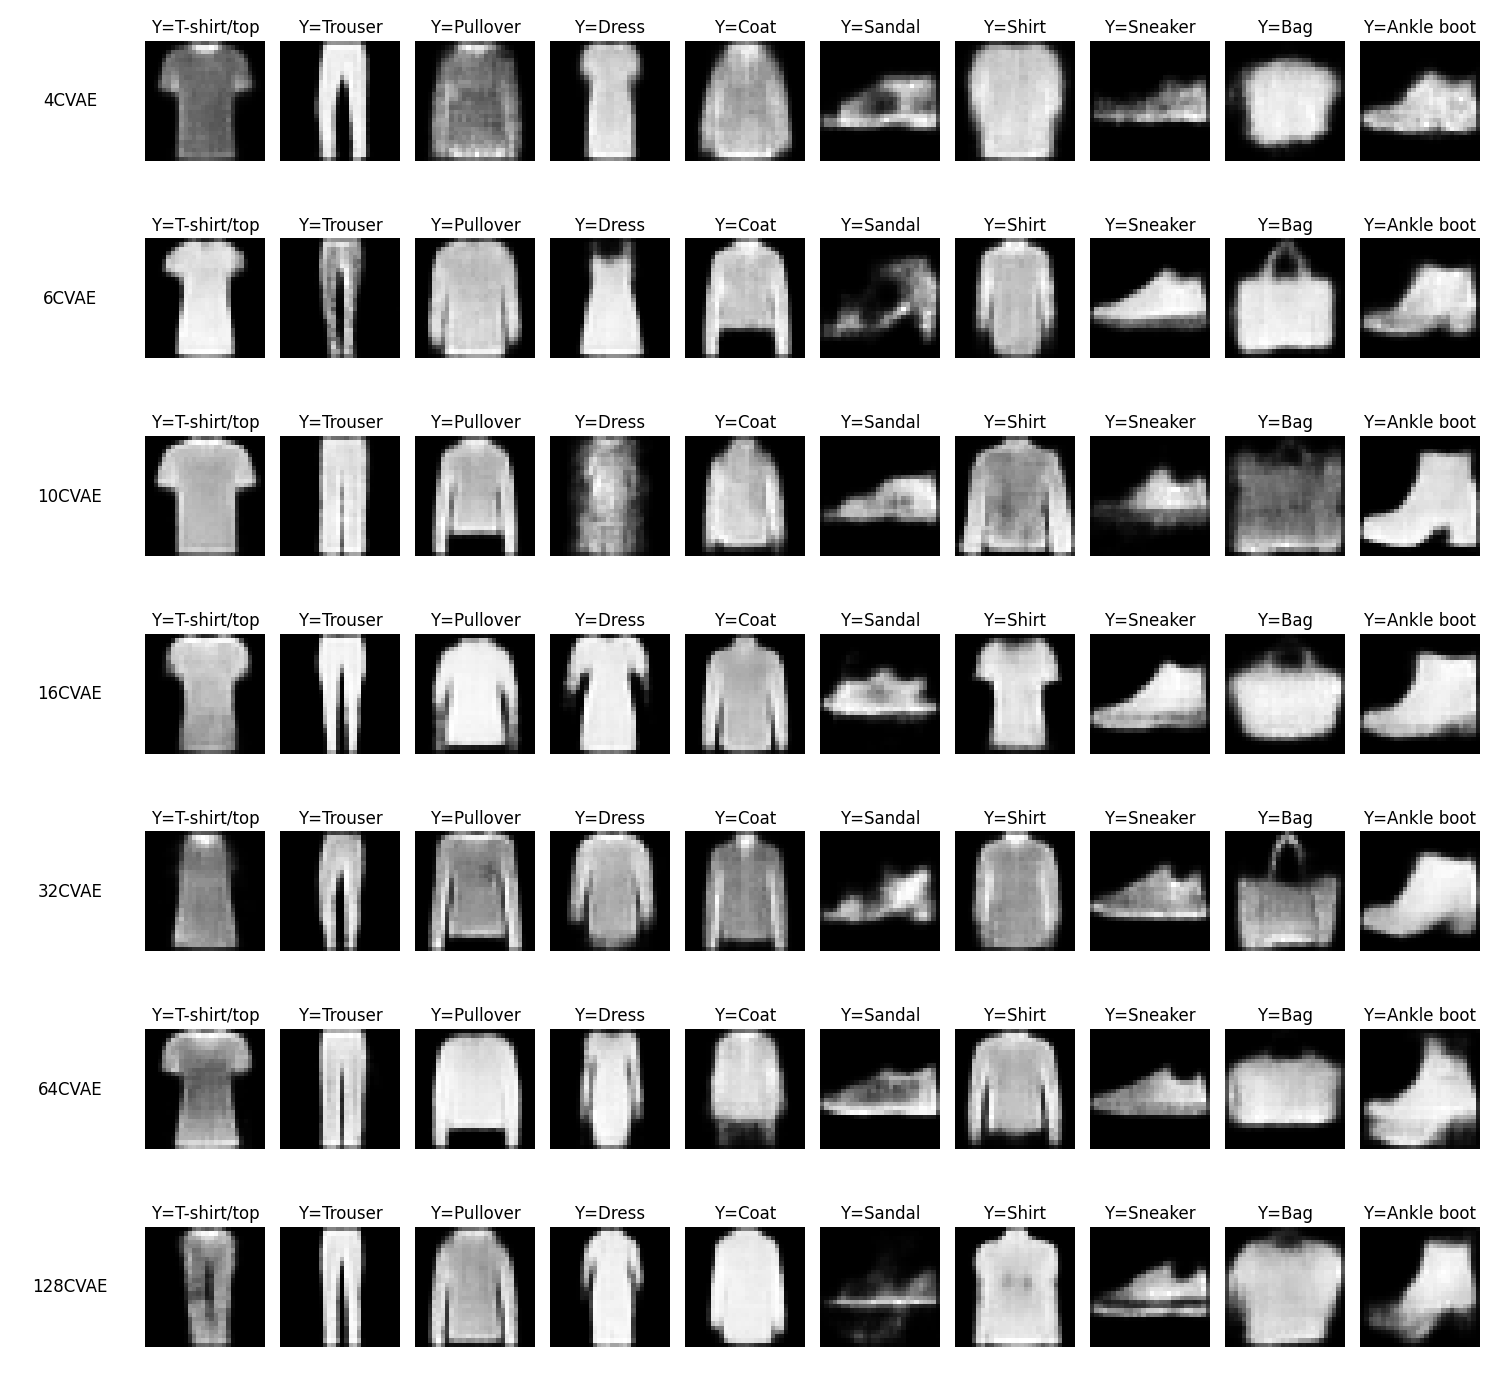

In [65]:
generate_samples_plot(models_dict=models_dict_latent)

On observe encore difficilement l'écart de performance des modèles sur les images générées

In [66]:
samples_dict_latent = generate_samples_dict(models_dict_latent, 10000)

### Résultats des tests automatiques

#### Test du classifieur

In [67]:
accuracy_latent = eval_classif_dict(samples_dict_latent)

print(accuracy_latent)

{'4CVAE': 82.87, '6CVAE': 84.03, '10CVAE': 82.47, '16CVAE': 82.83, '32CVAE': 82.72, '64CVAE': 81.37, '128CVAE': 80.17}


Au niveau de l'accuracy du classifieur, les modèles avec une dimension de l'espace latent inférieure à 32 donnent de meilleurs résultats que les autres.

#### Score FID

In [68]:
fid_score = comupte_fid_dict(samples_dict_latent, test_loader, batch_size=32)

print(fid_score)

Processing Batches: 100%|██████████| 79/79 [00:31<00:00,  2.48it/s]


{'4CVAE': tensor(0.4054, device='cuda:0'), '6CVAE': tensor(0.3365, device='cuda:0'), '10CVAE': tensor(0.2973, device='cuda:0'), '16CVAE': tensor(0.3035, device='cuda:0'), '32CVAE': tensor(0.3088, device='cuda:0'), '64CVAE': tensor(0.3192, device='cuda:0'), '128CVAE': tensor(0.3216, device='cuda:0')}


Pour le score FID, les modèles avec les meilleurs résultats sont ceux avec une dimension de l'espace latent de 10, 16 et 32. 

### Conclusion sur la partie

Au cours de cette partie, nous avons comparé les performances de nos modèles en fonction de la dimension de l'espace latent. En croisant les différentes méthodes utilisées, nous avons effectivement observé une dimension optimale comprise entre 10 et 32. Lorsqu'elle est plus petite, les performances diminuent, car le réseau ne retient plus suffisamment d'informations pour reconstruire les images. À l'inverse, lorsqu'elle est trop grande, le réseau sur-apprend et les performances sont également moins bonnes.

Pour la suite du projet, nous utiliserons un espace latent de taille 16.

## VII) Impact du coefficient KL

Le KL-Weight (aussi appelé $\beta$) est un hyperparamètre clé dans le cadre de la génération d'images par VAE ou CVAE. Il contrôle l'importance relative donnée à la divergence KL par rapport à l'erreur de reconstruction. Ainsi, une valeur élevée de ce coefficient privilégiera une distribution normale dans l'espace latent, tandis qu'une valeur faible améliorera la reconstruction des images par notre modèle.

Nous allons maintenant tester plusieurs valeurs de $\beta$ pour observer l'impact de ce paramètre sur notre problématique de génération d'images.

### Définition de l'architecture des classes

In [69]:
models_dict_kl = {
    'KL-1': config_model(CVAE, 16, LEARNING_RATE),
}

models_dict_kl2 = {
    'KL0': config_model(CVAE, 16, LEARNING_RATE),
}

models_dict_kl3 = {
    'KL1': config_model(CVAE, 16, LEARNING_RATE),
}

models_dict_kl4 = {
    'KL2': config_model(CVAE, 16, LEARNING_RATE),
}

### Entraînement des modèles

In [72]:
# On entraine chaque modèle séparément pour pouvoir faire varier bêta.

KL_WEIGHT = 1e-1
loss_dict_kl = train(dict_model=models_dict_kl, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

KL_WEIGHT2 = 1
loss_dict_kl2 = train(dict_model=models_dict_kl2, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT2, epochs=EPOCH)

KL_WEIGHT3 = 1e1
loss_dict_kl3 = train(dict_model=models_dict_kl3, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT3, epochs=EPOCH)

KL_WEIGHT4 = 1e2
loss_dict_kl4 = train(dict_model=models_dict_kl4, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT4, epochs=EPOCH)

Epoch 1: Model KL-1 - Loss: 248.4751, BCE: 244.3579, KLD: 41.1724
Epoch 2: Model KL-1 - Loss: 223.6875, BCE: 219.5639, KLD: 41.2356
Epoch 3: Model KL-1 - Loss: 220.3592, BCE: 216.2093, KLD: 41.4988
Epoch 4: Model KL-1 - Loss: 218.7593, BCE: 214.6107, KLD: 41.4859
Epoch 5: Model KL-1 - Loss: 217.8713, BCE: 213.7407, KLD: 41.3055
Epoch 6: Model KL-1 - Loss: 217.2105, BCE: 213.0954, KLD: 41.1507
Epoch 7: Model KL-1 - Loss: 216.6683, BCE: 212.5662, KLD: 41.0212
Epoch 8: Model KL-1 - Loss: 216.2423, BCE: 212.1571, KLD: 40.8522
Epoch 9: Model KL-1 - Loss: 215.9125, BCE: 211.8436, KLD: 40.6894
Epoch 10: Model KL-1 - Loss: 215.6512, BCE: 211.5977, KLD: 40.5351
Epoch 1: Model KL0 - Loss: 267.8036, BCE: 254.5932, KLD: 13.2104
Epoch 2: Model KL0 - Loss: 244.2057, BCE: 230.9345, KLD: 13.2713
Epoch 3: Model KL0 - Loss: 241.2592, BCE: 228.0691, KLD: 13.1901
Epoch 4: Model KL0 - Loss: 239.6576, BCE: 226.4762, KLD: 13.1814
Epoch 5: Model KL0 - Loss: 238.5099, BCE: 225.3239, KLD: 13.1860
Epoch 6: Model

### Affichage des pertes de nos modèles

#### Pertes au cours de l'entraînement

In [73]:
loss_dict_kl['evol_losses']['KL0'] = loss_dict_kl2['evol_losses']['KL0']
loss_dict_kl['evol_losses']['KL1'] = loss_dict_kl3['evol_losses']['KL1']
loss_dict_kl['evol_losses']['KL2'] = loss_dict_kl4['evol_losses']['KL2']

loss_dict_kl['evol_bce']['KL0'] = loss_dict_kl2['evol_bce']['KL0']
loss_dict_kl['evol_bce']['KL1'] = loss_dict_kl3['evol_bce']['KL1']
loss_dict_kl['evol_bce']['KL2'] = loss_dict_kl4['evol_bce']['KL2']

loss_dict_kl['evol_kl']['KL0'] = loss_dict_kl2['evol_kl']['KL0']
loss_dict_kl['evol_kl']['KL1'] = loss_dict_kl3['evol_kl']['KL1']
loss_dict_kl['evol_kl']['KL2'] = loss_dict_kl4['evol_kl']['KL2']

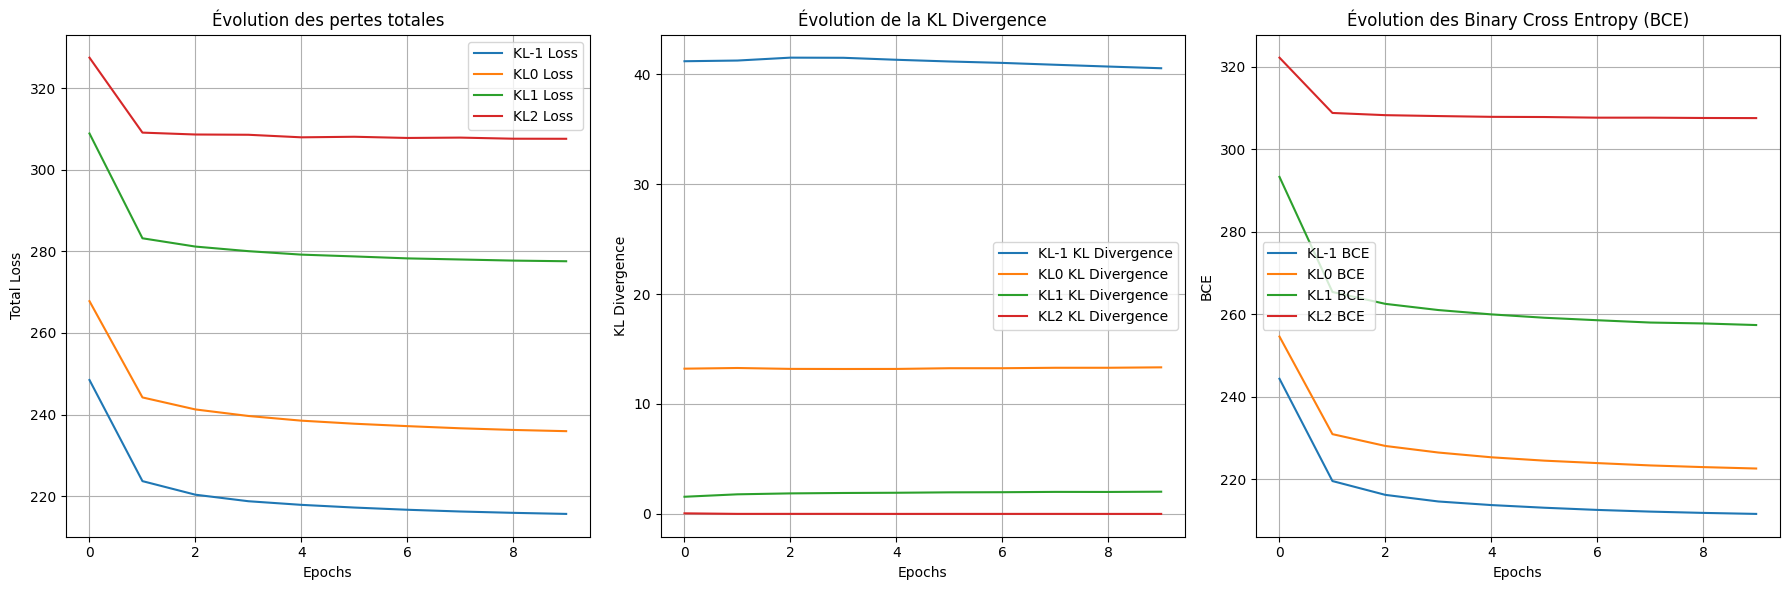

In [74]:
plot_losses(loss_dict_kl['evol_losses'], loss_dict_kl['evol_bce'], loss_dict_kl['evol_kl'])

Ici, nous ne pouvons pas comparer directement les pertes totales, car la fonction de perte utilisée n'est pas la même pour chaque modèle. On remarque néanmoins que la perte globale se stabilise plus rapidement pour une valeur de $\beta$ élevée.

Les résultats au niveau de la KL-Divergence et de la BCE sont cohérents avec ce que l'on pouvait attendre : une KL-Divergence faible et une erreur de reconstruction élevée lorsque $\beta$ est grand.

#### Pertes sur le jeu de test

In [75]:
loss_dict_kl1_test = evaluate(models_dict_kl, test_loader, device, kl_weight=KL_WEIGHT, have_labels=True)
loss_dict_kl2_test = evaluate(models_dict_kl2, test_loader, device, kl_weight=KL_WEIGHT2, have_labels=True)
loss_dict_kl3_test = evaluate(models_dict_kl3, test_loader, device, kl_weight=KL_WEIGHT3, have_labels=True)
loss_dict_kl4_test = evaluate(models_dict_kl4, test_loader, device, kl_weight=KL_WEIGHT4, have_labels=True)

In [91]:
print("Loss sur le jeu de test avec KL=0.1 : ", loss_dict_kl1_test['evol_losses']['KL-1'])
print("Loss sur le jeu de test avec KL=1 :", loss_dict_kl2_test['evol_losses']['KL0'])
print("Loss sur le jeu de test avec KL=10 : ", loss_dict_kl3_test['evol_losses']['KL1'])
print("Loss sur le jeu de test avec KL=100 :", loss_dict_kl4_test['evol_losses']['KL2'])

print("\nLoss BCE sur le jeu de test avec KL=0.1 : ", loss_dict_kl1_test['evol_bce']['KL-1'])
print("Loss BCE sur le jeu de test avec KL=1 : ", loss_dict_kl2_test['evol_bce']['KL0'])
print("Loss BCE sur le jeu de test avec KL=10 : ", loss_dict_kl3_test['evol_bce']['KL1'])
print("Loss BCE sur le jeu de test avec KL=100 : ", loss_dict_kl4_test['evol_bce']['KL2'])


print("\nLoss KL sur le jeu de test avec KL=0.1 : ", loss_dict_kl1_test['evol_kl']['KL-1'])
print("Loss KL sur le jeu de test avec KL=1 : ", loss_dict_kl2_test['evol_kl']['KL0'])
print("Loss KL sur le jeu de test avec KL=10 : ", loss_dict_kl3_test['evol_kl']['KL1'])
print("Loss KL sur le jeu de test avec KL=100 : ", loss_dict_kl4_test['evol_kl']['KL2'])


Loss sur le jeu de test avec KL=0.1 :  217.462419140625
Loss sur le jeu de test avec KL=1 : 237.5003807861328
Loss sur le jeu de test avec KL=10 :  279.0371885253906
Loss sur le jeu de test avec KL=100 : 309.0013328125

Loss BCE sur le jeu de test avec KL=0.1 :  213.42175759277345
Loss BCE sur le jeu de test avec KL=1 :  224.12925942382813
Loss BCE sur le jeu de test avec KL=10 :  258.8622451904297
Loss BCE sur le jeu de test avec KL=100 :  308.93651821289063

Loss KL sur le jeu de test avec KL=0.1 :  40.40661865234375
Loss KL sur le jeu de test avec KL=1 :  13.371121701049805
Loss KL sur le jeu de test avec KL=10 :  2.0174942974090575
Loss KL sur le jeu de test avec KL=100 :  0.0006481341898441315


Les pertes obtenues sur le jeu d'entraînement et sur le jeu de test sont similaires, ce qui indique que le modèle ne surapprend pas avec 10 époques.

### Comparaison des images reconstruites

In [76]:
models_dict_kl['KL0'] = models_dict_kl2['KL0']
models_dict_kl['KL1'] = models_dict_kl3['KL1']
models_dict_kl['KL2'] = models_dict_kl4['KL2']

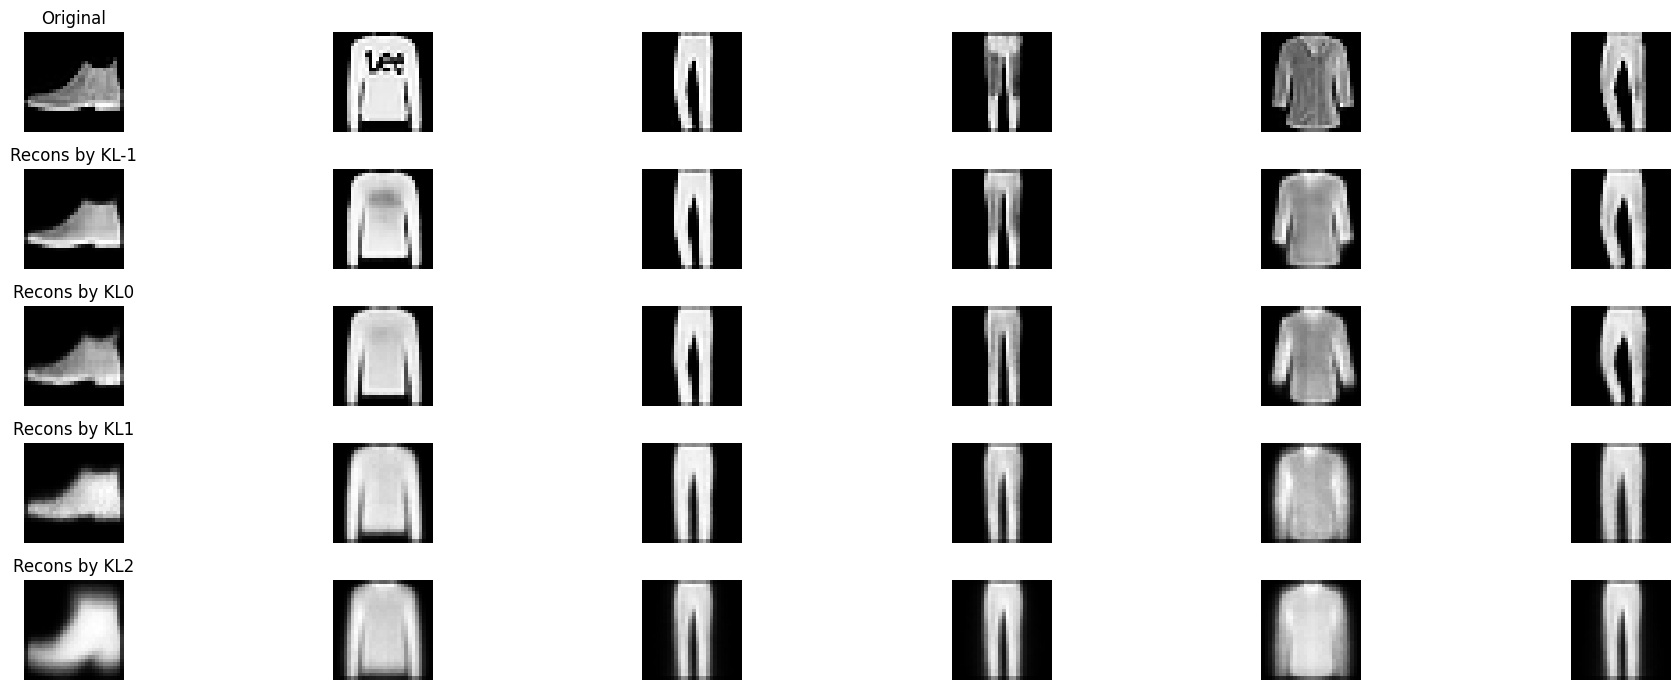

In [77]:
compare_model_reconstructions(models_dict_kl, test_loader, device)

On observe clairement ici que plus $\beta$ est faible, meilleure est la qualité de la reconstruction. En particulier, pour le modèle KL2, les images reconstruites apparaissent très floues et présentent peu de nuances de couleur.

 ### Comparaison des espaces latents

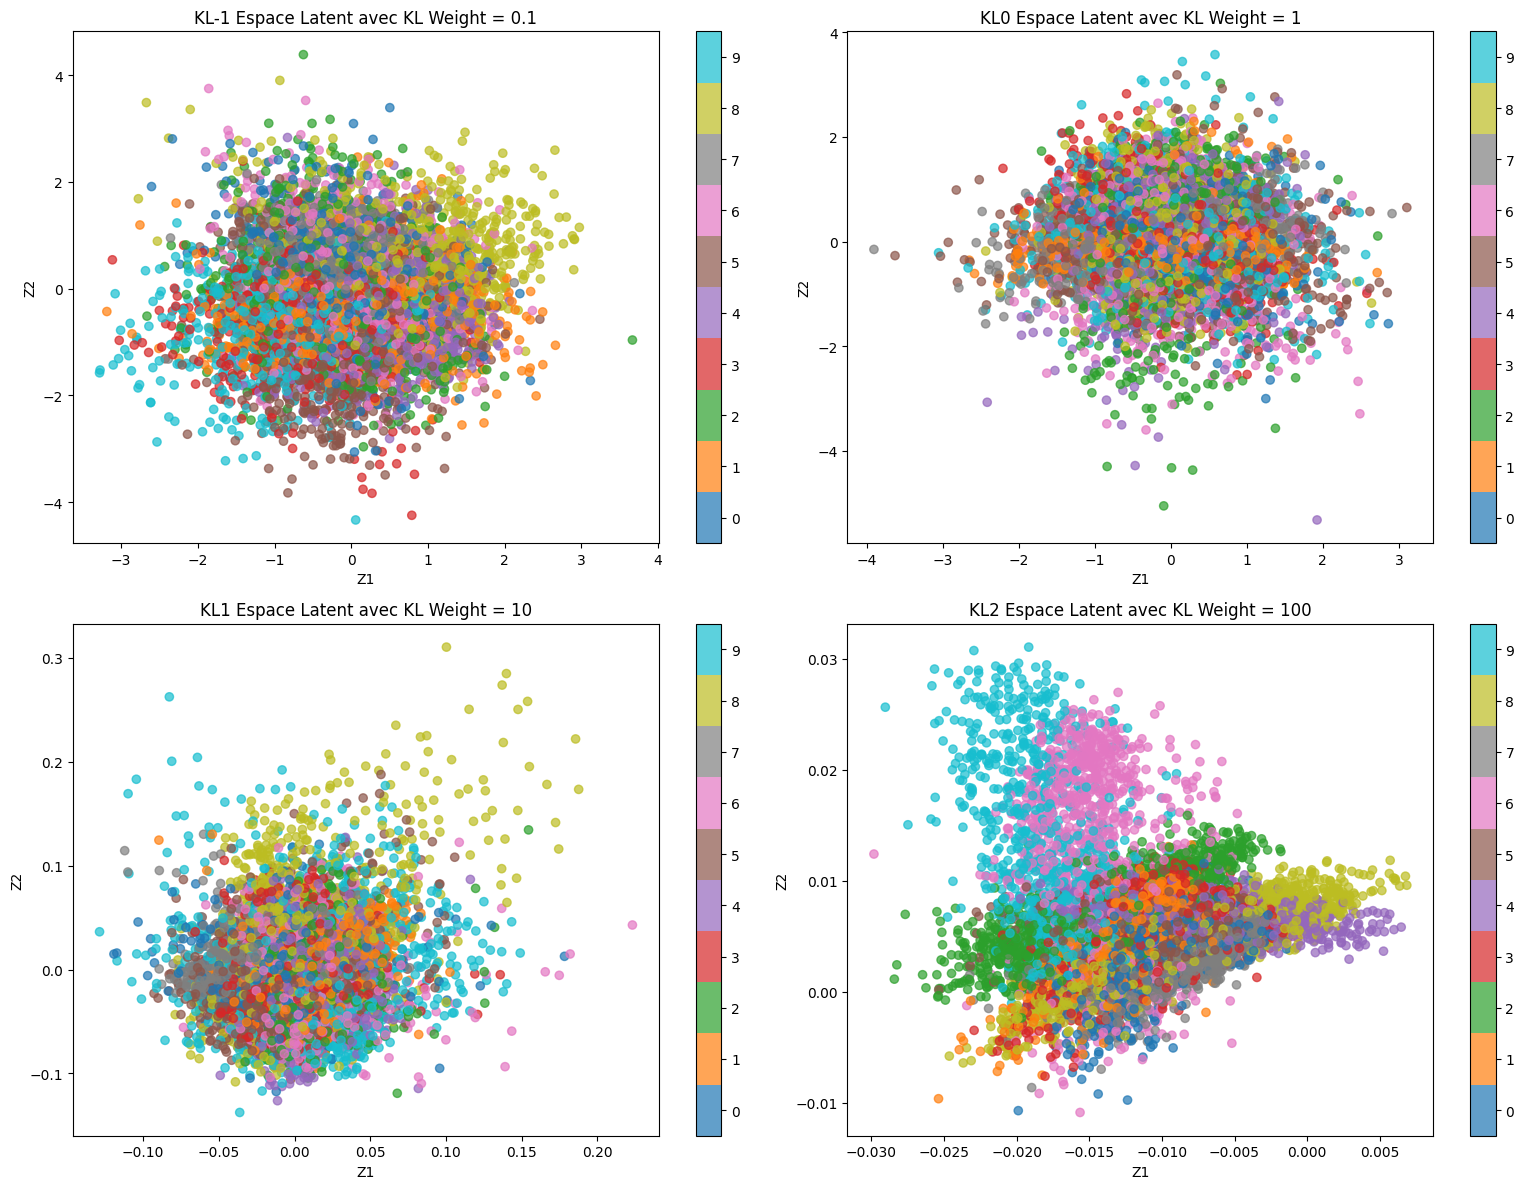

In [80]:
plot_latent_space(models_dict_kl, test_dataset, device, [0.1,1,10,100])

Au niveau des espaces latents, on remarque que plus le KL-Weight est élevé, plus les données de test se concentrent dans une petite zone de l'espace latent. Lorsque le KL-Weight vaut 100, une forme particulière apparaît, probablement en raison d'une régularisation excessive.

### Génération d'images

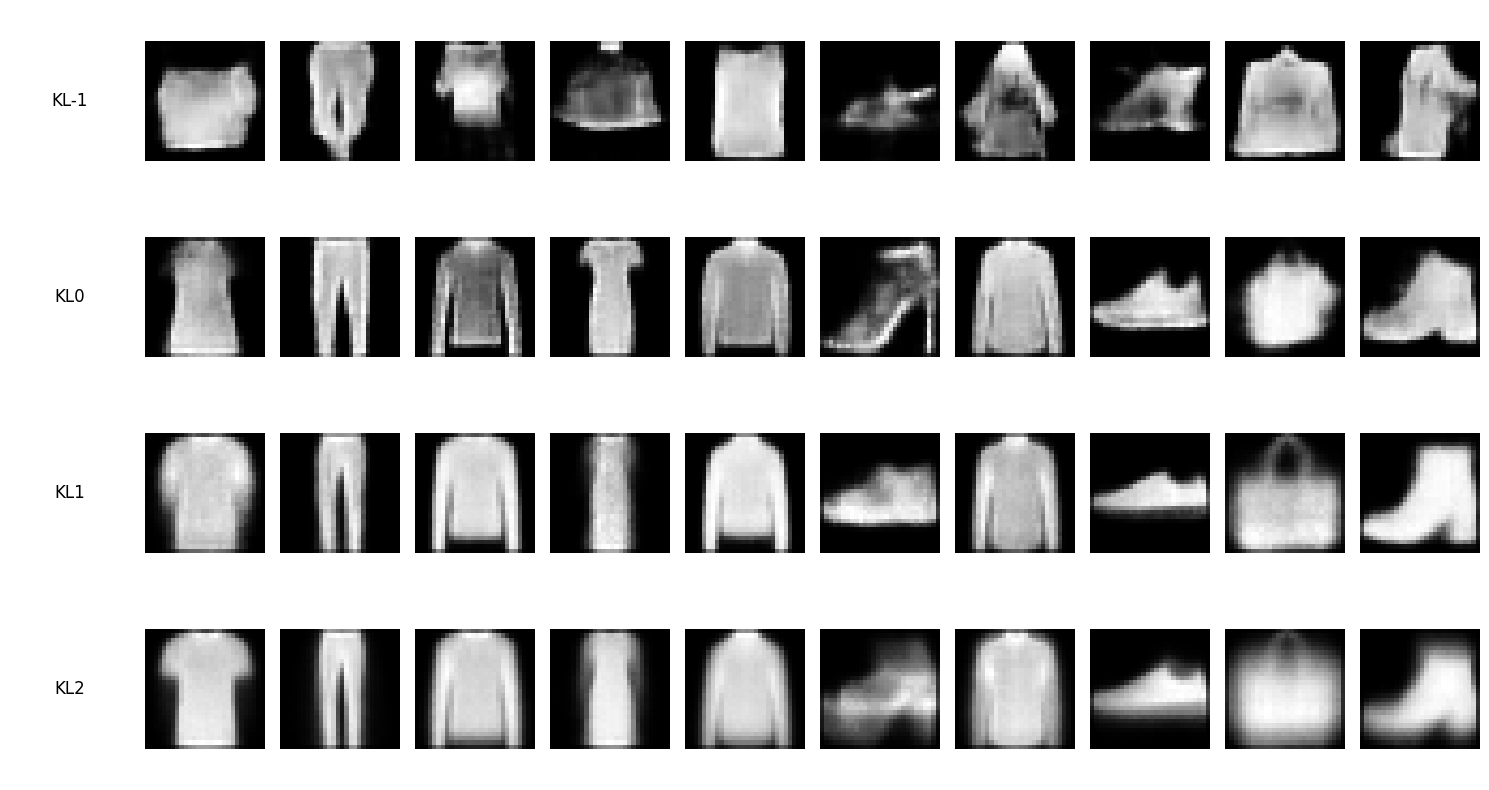

In [81]:
generate_samples_plot(models_dict=models_dict_kl)

On remarque que les images générées avec un $\beta$ faible sont très détaillées, affichant de nombreuses nuances de couleurs et de détails, mais elles manquent totalement de réalisme. À l'inverse, avec un $\beta$ élevé, les images générées sont plus simples, légèrement floues, mais nettement plus réalistes.

In [82]:
samples_dict_kl = generate_samples_dict(models_dict_kl, 10000)

### Résultats des tests automatiques

#### Test du classifieur

In [83]:
accuracy_kl = eval_classif_dict(samples_dict_kl)

print(accuracy_kl)

{'KL-1': 35.89, 'KL0': 82.65, 'KL1': 82.04, 'KL2': 75.53}


En utilisant notre classifieur, nous obtenons les meilleurs résultats pour $\beta$ égal à 1 et 10. Lorsque $\beta = 0.1$, les résultats sont extrêmement mauvais, probablement en raison du manque de réalisme des images générées. Pour $\beta = 100$, les performances sont également inférieures, probablement à cause du flou présent sur certaines images.

#### Score FID

In [84]:
fid_score = comupte_fid_dict(samples_dict_kl, test_loader, batch_size=32)

print(fid_score)

Processing Batches: 100%|██████████| 79/79 [00:31<00:00,  2.50it/s]


{'KL-1': tensor(0.4349, device='cuda:0'), 'KL0': tensor(0.2979, device='cuda:0'), 'KL1': tensor(0.6483, device='cuda:0'), 'KL2': tensor(1.1883, device='cuda:0')}


Pour le score FID, nous obtenons les meilleurs résultats pour $\beta = 1$, ce qui signifie que cette valeur permet de mieux représenter notre jeu de données.

Avec $\beta = 0.1$, les images générées sont probablement trop éloignées du jeu de données initial. À l'inverse, avec $\beta$ égal à 10 ou 100, les images sont plus réalistes, mais moins variées que celles du jeu de données initial.

### Conclusion sur la partie

Le choix de la valeur de KL-Weight ($\beta$) influence fortement la qualité des images générées. Nous avons en effet observé qu'avec un $\beta$ faible, le modèle reconstruit très bien les images, mais n'est pas capable de générer des données cohérentes. A l'inverse, avec un $\beta$ élevé, les images générées sont très réalites, mais plus simples et moins riches par rapport au jeu de données utilisé. Il est donc très important de trouver un bon compromis pour ce paramètre.

Dans notre cas, une valeur de $\beta$ autour de 1 semble offrir le meilleur équilibre entre qualité et réalisme des images générées.

## VIII) Sources utilisées pour ce projet

### Liens utiles sur les CVAE :

https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8

https://deepgram.com/ai-glossary/conditional-variational-autoencoders

https://pyro.ai/examples/cvae.html

https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html


### Liens utiles sur les méthodes permettant d'évaluer les CVAE :

https://dagshub.com/blog/how-to-evaluate-generative-image-models/

https://sh-tsang.medium.com/brief-review-stylegan-a-style-based-generator-architecture-for-generative-adversarial-networks-5051d79aad53

https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/

https://arxiv.org/pdf/1802.03446    


### Liens sur le FID :

https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance

https://strikingloo.github.io/wiki/fid


### Lien sur le test de Turing :

https://www.nature.com/articles/s41598-023-45290-1